# Image Deepfake Detection

## imports

In [ ]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 
import warnings
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense , Flatten , MaxPooling2D
from tensorflow.keras.applications import VGG16 , ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout
import gc
from tensorflow.keras.metrics import Precision, Recall, AUC
import numpy as np
import cv2
from sklearn.model_selection import KFold , StratifiedKFold
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from tensorflow.keras import backend as K
import gc
from keras.callbacks import ModelCheckpoint
from keras.applications import ResNet50 , VGG16

## Dataframe concatenating and shuffling 

read data to dataframe

In [3]:
real = pd.read_csv("/kaggle/input/real-data/real.csv")
high = pd.read_csv("/kaggle/input/high-new/high_new.csv")
low = pd.read_csv("/kaggle/input/low-quality/low.csv")

In [4]:
(high["x1"] == -1).sum()

37

In [5]:
high.drop(high[high["x1"] == -1].index, inplace=True)

In [6]:
high.shape

(33986, 8)

concatenate real andfake to create all data

In [7]:
real_low_df = pd.concat([real, low], ignore_index=True)
real_high_df = pd.concat([real, high], ignore_index=True)

shuffle the dataframes

In [8]:
shuffled_low_real = real_low_df.sample(frac=1, random_state=42).reset_index(drop=True)
shuffled_high_real = real_high_df.sample(frac=1, random_state=42).reset_index(drop=True)

check dataframes

In [9]:
shuffled_low_real.head(20)

,Image_Path,Person_Name,Person_Label,Label,x1,x2,y1,y2
0,/kaggle/input/d/mahdierahmati/deepfaketimit/De...,felc0,10,1,194,344,112,261
1,/kaggle/input/d/mahdierahmati/deepfaketimit/De...,mmdm2,9,1,178,327,145,294
2,/kaggle/input/d/mahdierahmati/deepfaketimit/De...,mdab0,19,1,178,327,112,261
3,/kaggle/input/d/mahdierahmati/deepfaketimit/De...,mdld0,22,1,154,333,114,293
4,/kaggle/input/vidtimit-audiovideo-dataset/mgwt...,mgwt0,37,0,154,333,94,273
5,/kaggle/input/vidtimit-audiovideo-dataset/fkms...,fkms0,59,0,154,333,154,333
6,/kaggle/input/d/mahdierahmati/deepfaketimit/De...,mpgl0,30,1,174,353,94,273
7,/kaggle/input/d/mahdierahmati/deepfaketimit/De...,fedw0,28,1,178,327,112,261
8,/kaggle/input/d/mahdierahmati/deepfaketimit/De...,mrgg0,1,1,137,352,113,328
9,/kaggle/input/vidtimit-audiovideo-dataset/mjsw...,mjsw0,40,0,194,373,134,313


In [10]:
shuffled_high_real.head(20)

,Image_Path,Person_Name,Person_Label,Label,x1,x2,y1,y2
0,/kaggle/input/d/mahdierahmati/deepfaketimit/De...,fram1,20,1,178,327,145,294
1,/kaggle/input/d/mahdierahmati/deepfaketimit/De...,mdld0,22,1,174,353,134,313
2,/kaggle/input/vidtimit-audiovideo-dataset/mcem...,mcem0,43,0,174,353,114,293
3,/kaggle/input/d/mahdierahmati/deepfaketimit/De...,fram1,20,1,178,327,161,311
4,/kaggle/input/vidtimit-audiovideo-dataset/fadg...,fadg0,36,0,174,353,94,273
5,/kaggle/input/d/mahdierahmati/deepfaketimit/De...,mdbb0,7,1,174,353,114,293
6,/kaggle/input/d/mahdierahmati/deepfaketimit/De...,mrcz0,24,1,174,353,114,293
7,/kaggle/input/d/mahdierahmati/deepfaketimit/De...,mmdm2,9,1,174,353,134,313
8,/kaggle/input/vidtimit-audiovideo-dataset/mdbb...,mdbb0,39,0,174,353,134,313
9,/kaggle/input/d/mahdierahmati/deepfaketimit/De...,fedw0,28,1,154,333,94,273


# custom data generator class
it will be fed with **shuffled_high_real** or **shuffled_low_real**

In [10]:
import cv2
import numpy as np
import tensorflow as tf
import math
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np


class MyDataGenerator(tf.keras.utils.Sequence):

    def __init__(self, dataframe, ids, batch_size, shuffle=True):
        self.df = dataframe[dataframe['Person_Label'].isin(ids)]
        self.batch_size = batch_size
        self.shuffle = shuffle
    
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, index):
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y

    def __get_faces(self, path, x1, x2, y1, y2):
        frame = cv2.imread(path)
        cropped_face = frame[y1:y2, x1:x2]
        resized_frame = cv2.resize(cropped_face, (224, 224))
        #normalized_frame = resized_frame / 255.0
        return resized_frame 

    def __get_data(self, batches):
        path_batch = batches['Image_Path']
        label_batch = batches['Label']
        x1_batch = batches['x1']
        x2_batch = batches['x2']
        y1_batch = batches['y1']
        y2_batch = batches['y2']

        X_batch = np.asarray([self.__get_faces(x, x1, x2, y1, y2) for x, x1, x2, y1, y2 in zip(path_batch, x1_batch, x2_batch, y1_batch, y2_batch)])
        y_batch = np.asarray(label_batch)
        return X_batch, y_batch

    def get_true_labels(self):
        return self.df['Label'].values
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
        

In [13]:
import cv2
import numpy as np
import tensorflow as tf
import math
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

class MyDataGenerator(tf.keras.utils.Sequence):

    def __init__(self, dataframe, ids, batch_size, seed=43, shuffle=True):
        self.df = dataframe[dataframe['Person_Label'].isin(ids)]
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.epoch = 0
    
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, index):
        batches = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y

    def __get_faces(self, path, x1, x2, y1, y2):
        frame = cv2.imread(path)
        cropped_face = frame[y1:y2, x1:x2]
        resized_frame = cv2.resize(cropped_face, (224, 224))
        # normalized_frame = resized_frame / 255.0
        return resized_frame 

    def __get_data(self, batches):
        path_batch = batches['Image_Path']
        label_batch = batches['Label']
        x1_batch = batches['x1']
        x2_batch = batches['x2']
        y1_batch = batches['y1']
        y2_batch = batches['y2']

        X_batch = np.asarray([self.__get_faces(x, x1, x2, y1, y2) for x, x1, x2, y1, y2 in zip(path_batch, x1_batch, x2_batch, y1_batch, y2_batch)])
        y_batch = np.asarray(label_batch)
        return X_batch, y_batch

    def get_true_labels(self):
        return self.df['Label'].values
    
    def on_epoch_end(self):
        if self.shuffle:
            # Update the seed using epoch number to ensure different shuffles each epoch
            epoch_seed = self.seed + self.epoch
            self.df = self.df.sample(frac=1, random_state=epoch_seed).reset_index(drop=True)
            self.epoch += 1

# Modeling - final models with plots 

In [37]:
size = (224, 224, 3)
resnet_base = ResNet50(weights='imagenet', include_top=True, input_shape=size)
resnet_base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [39]:
vgg_base = VGG16(weights='imagenet', include_top=True, input_shape=size)
vgg_base.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

# low quality - vgg16 - freeze

In [23]:
def create_model(size = (224 , 224 , 3)):
    
    vgg16_base = VGG16(weights='imagenet', include_top=True, input_shape= size)

    for layer in vgg16_base.layers:
        layer.trainable = False

    model = Sequential()
    model.add(vgg16_base)
    model.add(Dense(256, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy' ,Precision() , Recall() , AUC()])

    return model

In [25]:
num_folds = 4
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

Epochs = 20
batch_size = 64
epoch_list = list(range(1, Epochs + 1))
all_histories = []
result_train = []
result_test = []
all_y_true = []
all_y_pred_binary = []

#these two variables are used for kfold on persons. 
persons = np.arange(64)
labels = np.concatenate((np.ones(32), np.zeros(32)))


for fold_index, (train_index_p, test_index_p) in enumerate(kf.split(persons , labels)):
    
    K.clear_session()
    gc.collect()
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint_path = f"vgg_freeze__LQ_fold_{fold_index}.keras"
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    model = create_model((224 , 224 , 3)) 
    
    train_generator = MyDataGenerator(shuffled_low_real, train_index_p , batch_size)
    val_generator = MyDataGenerator(shuffled_low_real, test_index_p, batch_size )

    history = model.fit(train_generator, epochs=Epochs,validation_data=val_generator , callbacks = [checkpoint])

    all_histories.append(history.history)
    
    
    train_results = model.evaluate(train_generator)
    print("Metrics on train:")
    print(train_results)
    result_train.append(train_results)
        
    test_results = model.evaluate(val_generator)
    print("Metrics on test:")
    print(test_results)
    result_test.append(test_results)
    
    
    y_true =  val_generator.get_true_labels()
    y_pred = model.predict(val_generator)
    y_pred_binary = (y_pred > 0.5).astype(int) 
    all_y_pred_binary.append(y_pred_binary)
    all_y_true.append(y_true)

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1716117218.621576     317 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716117218.643842     317 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


759/790 ━━━━━━━━━━━━━━━━━━━━ 26s 843ms/step - accuracy: 0.7672 - auc: 0.8259 - loss: 0.6576 - precision: 0.7563 - recall: 0.7937

W0000 00:00:1716117858.027857     316 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


790/790 ━━━━━━━━━━━━━━━━━━━━ 0s 835ms/step - accuracy: 0.7685 - auc: 0.8274 - loss: 0.6558 - precision: 0.7576 - recall: 0.7947

W0000 00:00:1716117880.362488     318 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.76576, saving model to vgg_freeze__LQ_fold_0.keras


W0000 00:00:1716118143.332632     316 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


790/790 ━━━━━━━━━━━━━━━━━━━━ 991s 1s/step - accuracy: 0.7685 - auc: 0.8274 - loss: 0.6557 - precision: 0.7576 - recall: 0.7948 - val_accuracy: 0.7658 - val_auc: 0.8300 - val_loss: 0.5638 - val_precision: 0.7386 - val_recall: 0.8178
Epoch 2/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.8251 - auc: 0.9020 - loss: 0.4768 - precision: 0.8223 - recall: 0.8287
Epoch 2: val_accuracy improved from 0.76576 to 0.79316, saving model to vgg_freeze__LQ_fold_0.keras
790/790 ━━━━━━━━━━━━━━━━━━━━ 363s 456ms/step - accuracy: 0.8251 - auc: 0.9020 - loss: 0.4767 - precision: 0.8223 - recall: 0.8287 - val_accuracy: 0.7932 - val_auc: 0.8657 - val_loss: 0.4734 - val_precision: 0.7891 - val_recall: 0.7963
Epoch 3/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.8454 - auc: 0.9196 - loss: 0.3887 - precision: 0.8411 - recall: 0.8513
Epoch 3: val_accuracy improved from 0.79316 to 0.82279, saving model to vgg_freeze__LQ_fold_0.keras
790/790 ━━━━━━━━━━━━━━━━━━━━ 350s 440ms/step - accuracy

W0000 00:00:1716124723.218898     316 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Metrics on train:
[0.15075519680976868, 0.9469807744026184, 0.9879432320594788, 0.9481161832809448, 0.9460195899009705]
274/274 ━━━━━━━━━━━━━━━━━━━━ 82s 298ms/step - accuracy: 0.9041 - auc: 0.9646 - loss: 0.2449 - precision: 0.9187 - recall: 0.8844
Metrics on test:
[0.24406933784484863, 0.9051153063774109, 0.9648644924163818, 0.922135591506958, 0.8835498094558716]
  1/274 ━━━━━━━━━━━━━━━━━━━━ 4:54 1s/step

W0000 00:00:1716124806.897209     315 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


274/274 ━━━━━━━━━━━━━━━━━━━━ 76s 276ms/step


W0000 00:00:1716124882.197882     315 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/20


W0000 00:00:1716124890.823908     316 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


172/794 ━━━━━━━━━━━━━━━━━━━━ 3:02 293ms/step - accuracy: 0.7190 - auc: 0.7525 - loss: 0.6871 - precision: 0.6787 - recall: 0.8482

W0000 00:00:1716124989.083694     316 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.7946 - auc: 0.8574 - loss: 0.6555 - precision: 0.7564 - recall: 0.8752

W0000 00:00:1716125180.411093     315 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.73808, saving model to vgg_freeze__LQ_fold_1.keras


W0000 00:00:1716125268.199606     315 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


794/794 ━━━━━━━━━━━━━━━━━━━━ 385s 478ms/step - accuracy: 0.7946 - auc: 0.8575 - loss: 0.6555 - precision: 0.7565 - recall: 0.8752 - val_accuracy: 0.7381 - val_auc: 0.7969 - val_loss: 0.5934 - val_precision: 0.7690 - val_recall: 0.6836
Epoch 2/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8715 - auc: 0.9369 - loss: 0.4530 - precision: 0.8633 - recall: 0.8807
Epoch 2: val_accuracy improved from 0.73808 to 0.74470, saving model to vgg_freeze__LQ_fold_1.keras
794/794 ━━━━━━━━━━━━━━━━━━━━ 319s 399ms/step - accuracy: 0.8715 - auc: 0.9369 - loss: 0.4529 - precision: 0.8634 - recall: 0.8807 - val_accuracy: 0.7447 - val_auc: 0.8074 - val_loss: 0.5469 - val_precision: 0.7679 - val_recall: 0.7043
Epoch 3/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8921 - auc: 0.9506 - loss: 0.3340 - precision: 0.8920 - recall: 0.8922
Epoch 3: val_accuracy improved from 0.74470 to 0.75341, saving model to vgg_freeze__LQ_fold_1.keras
794/794 ━━━━━━━━━━━━━━━━━━━━ 318s 398ms/step - accur

W0000 00:00:1716131554.558242     317 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


794/794 ━━━━━━━━━━━━━━━━━━━━ 232s 292ms/step - accuracy: 0.9650 - auc: 0.9939 - loss: 0.1032 - precision: 0.9661 - recall: 0.9641
Metrics on train:
[0.10298807919025421, 0.964768648147583, 0.9939785003662109, 0.9653961658477783, 0.9640268087387085]
270/270 ━━━━━━━━━━━━━━━━━━━━ 78s 286ms/step - accuracy: 0.7954 - auc: 0.8579 - loss: 0.6269 - precision: 0.7855 - recall: 0.8186
Metrics on test:
[0.617623507976532, 0.7943550944328308, 0.8602981567382812, 0.7857303023338318, 0.8116394877433777]
  1/270 ━━━━━━━━━━━━━━━━━━━━ 4:13 941ms/step

W0000 00:00:1716131633.908256     318 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


270/270 ━━━━━━━━━━━━━━━━━━━━ 74s 273ms/step


W0000 00:00:1716131707.347029     317 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/20


W0000 00:00:1716131715.535299     315 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


387/804 ━━━━━━━━━━━━━━━━━━━━ 2:22 342ms/step - accuracy: 0.7261 - auc: 0.8079 - loss: 0.6785 - precision: 0.6960 - recall: 0.8391

W0000 00:00:1716131847.592629     315 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


804/804 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.7581 - auc: 0.8312 - loss: 0.6590 - precision: 0.7361 - recall: 0.8264

W0000 00:00:1716131976.956374     316 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.85074, saving model to vgg_freeze__LQ_fold_2.keras


W0000 00:00:1716132099.043367     317 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


804/804 ━━━━━━━━━━━━━━━━━━━━ 391s 480ms/step - accuracy: 0.7582 - auc: 0.8313 - loss: 0.6589 - precision: 0.7361 - recall: 0.8264 - val_accuracy: 0.8507 - val_auc: 0.9227 - val_loss: 0.5091 - val_precision: 0.8341 - val_recall: 0.8757
Epoch 2/20
804/804 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.8292 - auc: 0.8997 - loss: 0.4907 - precision: 0.8299 - recall: 0.8285
Epoch 2: val_accuracy did not improve from 0.85074
804/804 ━━━━━━━━━━━━━━━━━━━━ 339s 418ms/step - accuracy: 0.8292 - auc: 0.8997 - loss: 0.4906 - precision: 0.8299 - recall: 0.8285 - val_accuracy: 0.8501 - val_auc: 0.9280 - val_loss: 0.4035 - val_precision: 0.8172 - val_recall: 0.9022
Epoch 3/20
804/804 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.8566 - auc: 0.9242 - loss: 0.3873 - precision: 0.8580 - recall: 0.8552
Epoch 3: val_accuracy improved from 0.85074 to 0.85314, saving model to vgg_freeze__LQ_fold_2.keras
804/804 ━━━━━━━━━━━━━━━━━━━━ 333s 412ms/step - accuracy: 0.8566 - auc: 0.9242 - loss: 0.3872 - precis

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



803/803 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.8887 - auc: 0.9515 - loss: 0.2964 - precision: 0.8872 - recall: 0.8893
Epoch 5: val_accuracy improved from 0.84043 to 0.84727, saving model to vgg_freeze__LQ_fold_3.keras
803/803 ━━━━━━━━━━━━━━━━━━━━ 308s 381ms/step - accuracy: 0.8887 - auc: 0.9515 - loss: 0.2964 - precision: 0.8872 - recall: 0.8893 - val_accuracy: 0.8473 - val_auc: 0.9362 - val_loss: 0.3285 - val_precision: 0.8388 - val_recall: 0.8613
Epoch 6/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8950 - auc: 0.9585 - loss: 0.2737 - precision: 0.8957 - recall: 0.8921
Epoch 6: val_accuracy improved from 0.84727 to 0.85470, saving model to vgg_freeze__LQ_fold_3.keras
803/803 ━━━━━━━━━━━━━━━━━━━━ 310s 383ms/step - accuracy: 0.8950 - auc: 0.9585 - loss: 0.2737 - precision: 0.8957 - recall: 0.8921 - val_accuracy: 0.8547 - val_auc: 0.9414 - val_loss: 0.3121 - val_precision: 0.8588 - val_recall: 0.8505
Epoch 7/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accurac

W0000 00:00:1716145104.475038     318 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Metrics on train:
[0.1458544284105301, 0.948451817035675, 0.9881962537765503, 0.9451583027839661, 0.952048659324646]
261/261 ━━━━━━━━━━━━━━━━━━━━ 75s 285ms/step - accuracy: 0.8965 - auc: 0.9668 - loss: 0.2317 - precision: 0.9061 - recall: 0.8850
Metrics on test:
[0.23222032189369202, 0.8961981534957886, 0.9667649865150452, 0.9044950604438782, 0.886884868144989]
  1/261 ━━━━━━━━━━━━━━━━━━━━ 4:05 944ms/step

W0000 00:00:1716145180.919953     317 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


261/261 ━━━━━━━━━━━━━━━━━━━━ 71s 268ms/step


W0000 00:00:1716145250.627500     316 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


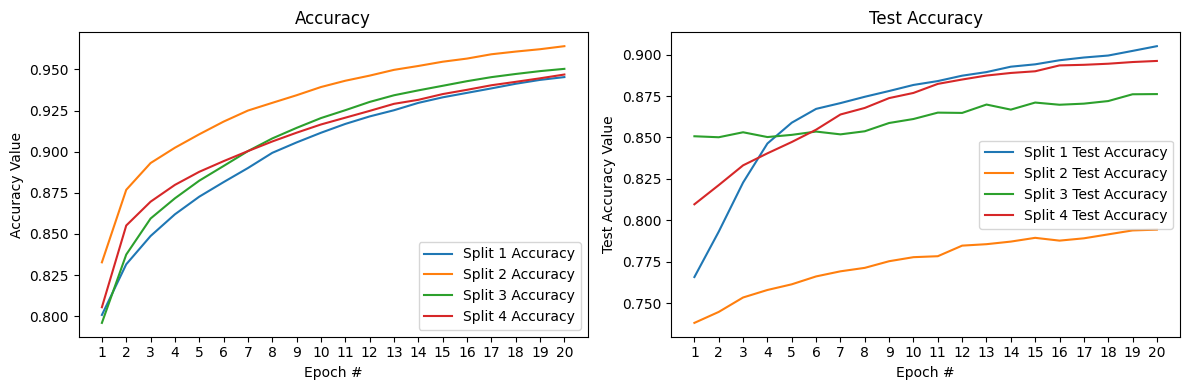

In [3]:
plot_metrics(all_histories, ["accuracy" , "val_accuracy"] )

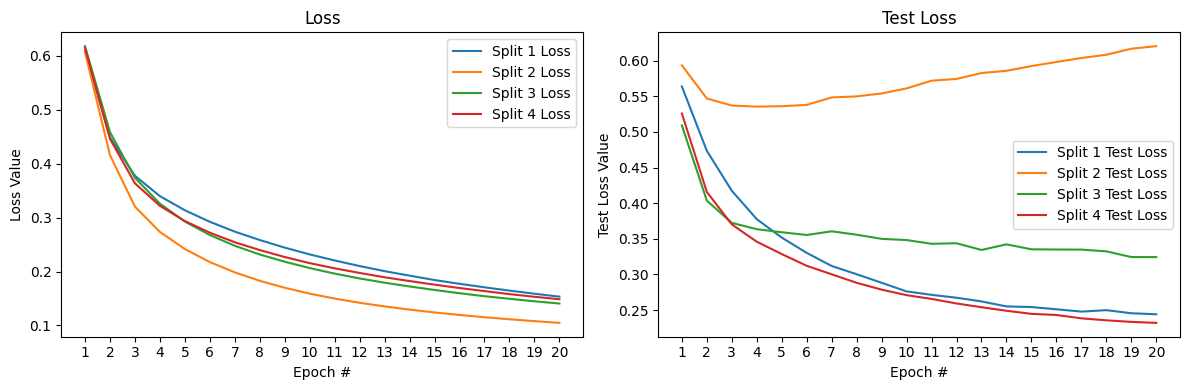

In [4]:
plot_metrics(all_histories, ["loss" , "val_loss"] )

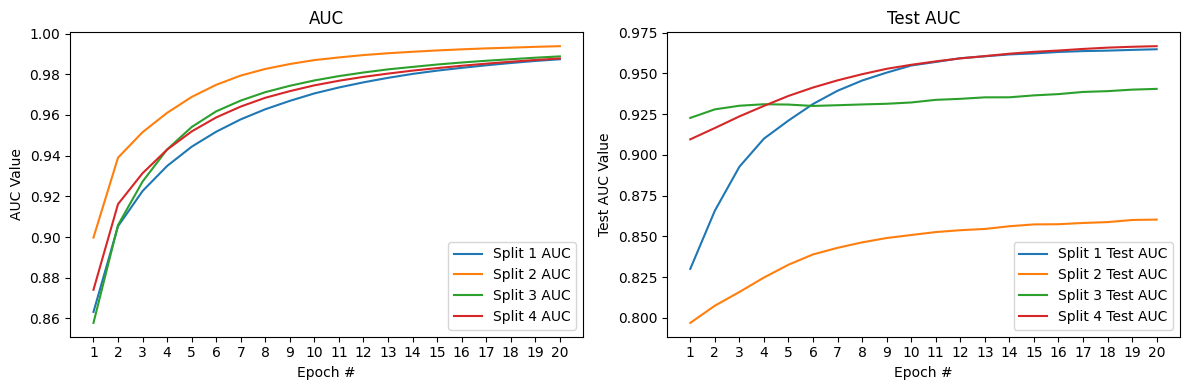

In [5]:
plot_metrics(all_histories, ["auc" , "val_auc"] )

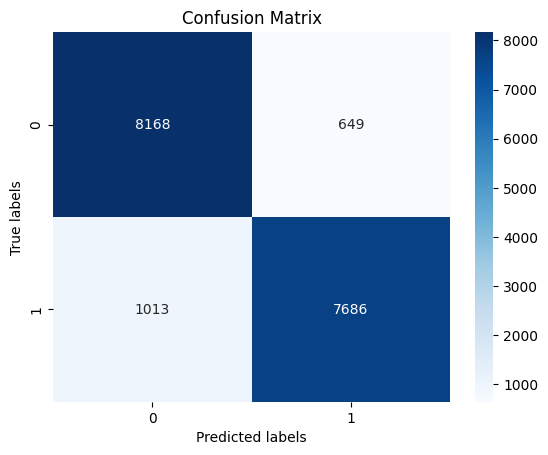

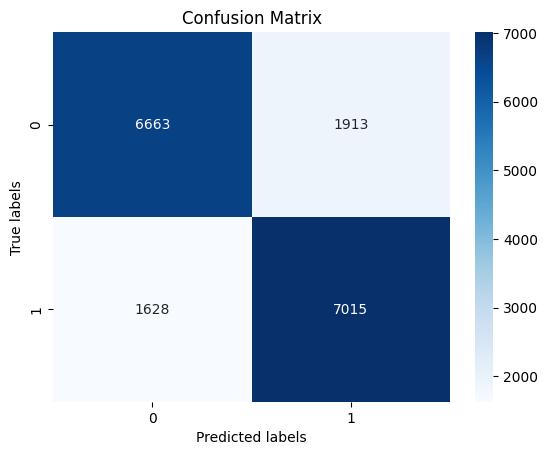

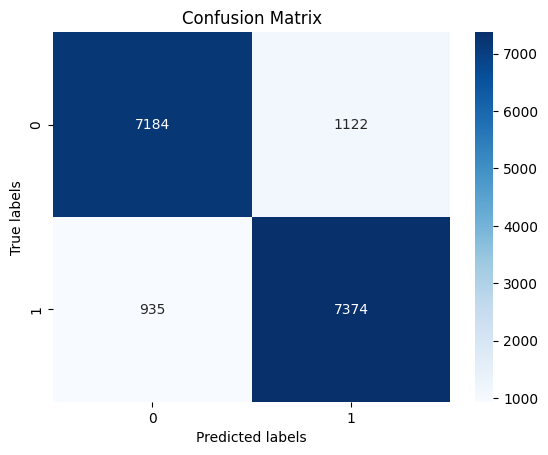

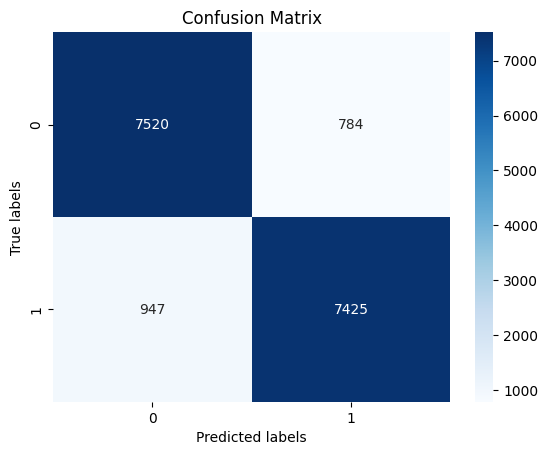

In [44]:
for i in range(4):
    plot_confusion_matrix(all_y_true[i], all_y_pred_binary[i] , [0 , 1])

In [45]:
for i in range(4):
    print(classification_report(all_y_true[i], all_y_pred_binary[i]))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      8817
           1       0.92      0.88      0.90      8699

    accuracy                           0.91     17516
   macro avg       0.91      0.90      0.91     17516
weighted avg       0.91      0.91      0.91     17516

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      8576
           1       0.79      0.81      0.80      8643

    accuracy                           0.79     17219
   macro avg       0.79      0.79      0.79     17219
weighted avg       0.79      0.79      0.79     17219

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      8306
           1       0.87      0.89      0.88      8309

    accuracy                           0.88     16615
   macro avg       0.88      0.88      0.88     16615
weighted avg       0.88      0.88      0.88     16615

              preci

# low quality - resnet50 - freeze

In [14]:
def create_model(size = (224 , 224 , 3)):
    #with strategy.scope():
    vgg16_base = ResNet50(weights='imagenet', include_top=True, input_shape= size)

    for layer in vgg16_base.layers:
        layer.trainable = False

    model = Sequential()
    model.add(vgg16_base)
        #model.add(Flatten())
    model.add(Dense(256, activation='relu'))
        #model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy' ,Precision() , Recall() , AUC()])

    return model

In [15]:
num_folds = 4
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

Epochs = 20
batch_size = 64
epoch_list = list(range(1, Epochs + 1))
all_histories = []
result_train = []
result_test = []
all_y_true = []
all_y_pred_binary = []

#these two variables are used for kfold on persons. 
persons = np.arange(64)
labels = np.concatenate((np.ones(32), np.zeros(32)))


for fold_index, (train_index_p, test_index_p) in enumerate(kf.split(persons , labels)):
    
    K.clear_session()
    gc.collect()
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint_path = f"resnet_freeze_LQ_fold_{fold_index}.keras"
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    model = create_model((224 , 224 , 3)) 
    
    train_generator = MyDataGenerator(shuffled_low_real, train_index_p , batch_size)
    val_generator = MyDataGenerator(shuffled_low_real, test_index_p, batch_size )

    history = model.fit(train_generator, epochs=Epochs,validation_data=val_generator , callbacks = [checkpoint])

    all_histories.append(history.history)
    
    
    train_results = model.evaluate(train_generator)
    print("Metrics on train:")
    print(train_results)
    result_train.append(train_results)
        
    test_results = model.evaluate(val_generator)
    print("Metrics on test:")
    print(test_results)
    result_test.append(test_results)
    
    
    y_true =  val_generator.get_true_labels()
    y_pred = model.predict(val_generator)
    y_pred_binary = (y_pred > 0.5).astype(int) 
    all_y_pred_binary.append(y_pred_binary)
    all_y_true.append(y_true)

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


I0000 00:00:1716621290.728538     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716621290.782217     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


595/790 ━━━━━━━━━━━━━━━━━━━━ 2:37 807ms/step - accuracy: 0.6619 - auc: 0.7220 - loss: 0.6778 - precision: 0.7118 - recall: 0.5466

W0000 00:00:1716621770.018136     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


790/790 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - accuracy: 0.6722 - auc: 0.7302 - loss: 0.6722 - precision: 0.7108 - recall: 0.5834

W0000 00:00:1716621923.285140     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.65163, saving model to resnet_freeze_LQ_fold_0.keras


W0000 00:00:1716622145.504131     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


790/790 ━━━━━━━━━━━━━━━━━━━━ 886s 1s/step - accuracy: 0.6722 - auc: 0.7302 - loss: 0.6722 - precision: 0.7108 - recall: 0.5836 - val_accuracy: 0.6516 - val_auc: 0.7073 - val_loss: 0.6450 - val_precision: 0.6533 - val_recall: 0.6363
Epoch 2/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.7619 - auc: 0.8264 - loss: 0.5732 - precision: 0.7390 - recall: 0.8088
Epoch 2: val_accuracy improved from 0.65163 to 0.70216, saving model to resnet_freeze_LQ_fold_0.keras
790/790 ━━━━━━━━━━━━━━━━━━━━ 377s 474ms/step - accuracy: 0.7619 - auc: 0.8264 - loss: 0.5731 - precision: 0.7390 - recall: 0.8088 - val_accuracy: 0.7022 - val_auc: 0.7707 - val_loss: 0.5867 - val_precision: 0.6733 - val_recall: 0.7777
Epoch 3/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.8024 - auc: 0.8840 - loss: 0.4912 - precision: 0.7784 - recall: 0.8455
Epoch 3: val_accuracy improved from 0.70216 to 0.73715, saving model to resnet_freeze_LQ_fold_0.keras
790/790 ━━━━━━━━━━━━━━━━━━━━ 355s 446ms/step - accu

W0000 00:00:1716629007.023194     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Metrics on train:
[0.1552664041519165, 0.9496139287948608, 0.988335907459259, 0.9488118886947632, 0.9507976770401001]
274/274 ━━━━━━━━━━━━━━━━━━━━ 98s 357ms/step - accuracy: 0.8185 - auc: 0.8957 - loss: 0.4855 - precision: 0.8240 - recall: 0.8049
Metrics on test:
[0.48709195852279663, 0.8187942504882812, 0.8965185284614563, 0.8301661014556885, 0.7984825968742371]
  2/274 ━━━━━━━━━━━━━━━━━━━━ 44s 164ms/step

W0000 00:00:1716629110.381083     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


274/274 ━━━━━━━━━━━━━━━━━━━━ 90s 312ms/step


W0000 00:00:1716629195.615995     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/20
  1/794 ━━━━━━━━━━━━━━━━━━━━ 3:13:37 15s/step - accuracy: 0.4844 - auc: 0.5324 - loss: 0.6929 - precision: 0.4211 - recall: 0.2667

W0000 00:00:1716629212.633058     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 82/794 ━━━━━━━━━━━━━━━━━━━━ 5:51 494ms/step - accuracy: 0.5556 - auc: 0.5581 - loss: 0.6923 - precision: 0.5783 - recall: 0.3876

W0000 00:00:1716629252.629283     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.6711 - auc: 0.7226 - loss: 0.6751 - precision: 0.6591 - recall: 0.6965

W0000 00:00:1716629501.109139     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.60613, saving model to resnet_freeze_LQ_fold_1.keras


W0000 00:00:1716629603.886621     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


794/794 ━━━━━━━━━━━━━━━━━━━━ 407s 494ms/step - accuracy: 0.6711 - auc: 0.7227 - loss: 0.6750 - precision: 0.6591 - recall: 0.6966 - val_accuracy: 0.6061 - val_auc: 0.6885 - val_loss: 0.6488 - val_precision: 0.5908 - val_recall: 0.7002
Epoch 2/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.7526 - auc: 0.8369 - loss: 0.5767 - precision: 0.7237 - recall: 0.8144
Epoch 2: val_accuracy improved from 0.60613 to 0.64946, saving model to resnet_freeze_LQ_fold_1.keras
794/794 ━━━━━━━━━━━━━━━━━━━━ 385s 481ms/step - accuracy: 0.7526 - auc: 0.8369 - loss: 0.5767 - precision: 0.7237 - recall: 0.8144 - val_accuracy: 0.6495 - val_auc: 0.7441 - val_loss: 0.6077 - val_precision: 0.6292 - val_recall: 0.7344
Epoch 3/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.7947 - auc: 0.8875 - loss: 0.4867 - precision: 0.7701 - recall: 0.8425
Epoch 3: val_accuracy improved from 0.64946 to 0.71566, saving model to resnet_freeze_LQ_fold_1.keras
794/794 ━━━━━━━━━━━━━━━━━━━━ 368s 460ms/step - a

W0000 00:00:1716636933.183891     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Metrics on train:
[0.12793029844760895, 0.9608518481254578, 0.9919095039367676, 0.9502598643302917, 0.9725374579429626]
270/270 ━━━━━━━━━━━━━━━━━━━━ 99s 367ms/step - accuracy: 0.8253 - auc: 0.8683 - loss: 0.5473 - precision: 0.8247 - recall: 0.8309
Metrics on test:
[0.5201291441917419, 0.8292003273963928, 0.8759942650794983, 0.8243458271026611, 0.8383663296699524]
  2/270 ━━━━━━━━━━━━━━━━━━━━ 46s 173ms/step

W0000 00:00:1716637037.938030     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


270/270 ━━━━━━━━━━━━━━━━━━━━ 89s 316ms/step


W0000 00:00:1716637122.855958     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/20
  1/804 ━━━━━━━━━━━━━━━━━━━━ 3:18:52 15s/step - accuracy: 0.5156 - auc: 0.4545 - loss: 0.6928 - precision: 0.5172 - recall: 0.9091

W0000 00:00:1716637140.597229     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


587/804 ━━━━━━━━━━━━━━━━━━━━ 1:17 356ms/step - accuracy: 0.6529 - auc: 0.7260 - loss: 0.6816 - precision: 0.6106 - recall: 0.8785

W0000 00:00:1716637349.582723     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


804/804 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.6672 - auc: 0.7375 - loss: 0.6762 - precision: 0.6260 - recall: 0.8624

W0000 00:00:1716637431.165173     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.64965, saving model to resnet_freeze_LQ_fold_2.keras


W0000 00:00:1716637534.512757     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


804/804 ━━━━━━━━━━━━━━━━━━━━ 409s 491ms/step - accuracy: 0.6672 - auc: 0.7375 - loss: 0.6762 - precision: 0.6261 - recall: 0.8623 - val_accuracy: 0.6497 - val_auc: 0.6791 - val_loss: 0.6454 - val_precision: 0.6343 - val_recall: 0.7069
Epoch 2/20
804/804 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.7671 - auc: 0.8340 - loss: 0.5788 - precision: 0.7552 - recall: 0.7945
Epoch 2: val_accuracy improved from 0.64965 to 0.67319, saving model to resnet_freeze_LQ_fold_2.keras
804/804 ━━━━━━━━━━━━━━━━━━━━ 375s 463ms/step - accuracy: 0.7671 - auc: 0.8340 - loss: 0.5788 - precision: 0.7552 - recall: 0.7945 - val_accuracy: 0.6732 - val_auc: 0.7397 - val_loss: 0.5898 - val_precision: 0.6670 - val_recall: 0.6919
Epoch 3/20
804/804 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8195 - auc: 0.8986 - loss: 0.4737 - precision: 0.8078 - recall: 0.8391
Epoch 3: val_accuracy improved from 0.67319 to 0.71688, saving model to resnet_freeze_LQ_fold_2.keras
804/804 ━━━━━━━━━━━━━━━━━━━━ 372s 459ms/step - a

W0000 00:00:1716644410.273563     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Metrics on train:
[0.13830295205116272, 0.9511777758598328, 0.9904129505157471, 0.9490285515785217, 0.953605055809021]
260/260 ━━━━━━━━━━━━━━━━━━━━ 81s 310ms/step - accuracy: 0.8330 - auc: 0.9033 - loss: 0.4248 - precision: 0.8351 - recall: 0.8330
Metrics on test:
[0.4197675585746765, 0.8362323045730591, 0.906792938709259, 0.8353336453437805, 0.837645947933197]
  2/260 ━━━━━━━━━━━━━━━━━━━━ 38s 149ms/step

W0000 00:00:1716644496.379459     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


260/260 ━━━━━━━━━━━━━━━━━━━━ 88s 321ms/step


W0000 00:00:1716644579.405207     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/20
  1/803 ━━━━━━━━━━━━━━━━━━━━ 3:21:50 15s/step - accuracy: 0.5312 - auc: 0.4673 - loss: 0.6934 - precision: 0.5349 - recall: 0.6970

W0000 00:00:1716644597.465951     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


579/803 ━━━━━━━━━━━━━━━━━━━━ 1:13 328ms/step - accuracy: 0.6478 - auc: 0.7367 - loss: 0.6811 - precision: 0.6038 - recall: 0.8807

W0000 00:00:1716644787.318882     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


803/803 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.6612 - auc: 0.7472 - loss: 0.6752 - precision: 0.6173 - recall: 0.8693

W0000 00:00:1716644864.864956     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.72349, saving model to resnet_freeze_LQ_fold_3.keras


W0000 00:00:1716644958.900825     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


803/803 ━━━━━━━━━━━━━━━━━━━━ 377s 452ms/step - accuracy: 0.6613 - auc: 0.7472 - loss: 0.6752 - precision: 0.6173 - recall: 0.8693 - val_accuracy: 0.7235 - val_auc: 0.7720 - val_loss: 0.6256 - val_precision: 0.7314 - val_recall: 0.7099
Epoch 2/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.7612 - auc: 0.8435 - loss: 0.5725 - precision: 0.7374 - recall: 0.8081
Epoch 2: val_accuracy did not improve from 0.72349
803/803 ━━━━━━━━━━━━━━━━━━━━ 333s 412ms/step - accuracy: 0.7612 - auc: 0.8435 - loss: 0.5724 - precision: 0.7374 - recall: 0.8081 - val_accuracy: 0.7229 - val_auc: 0.7873 - val_loss: 0.5771 - val_precision: 0.7498 - val_recall: 0.6725
Epoch 3/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 334s 413ms/step - accuracy: 0.8028 - auc: 0.8831 - loss: 0.4871 - precision: 0.7860 - recall: 0.8285 - val_accuracy: 0.7524 - val_auc: 0.8210 - val_loss: 0.5278 - val_precision: 0.7682 - val_recall: 0.7258
Epoch 4/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.8351 - auc: 0.9109 - loss:

W0000 00:00:1716651605.738153     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Metrics on train:
[0.1678466647863388, 0.9442453980445862, 0.9859763383865356, 0.9366855621337891, 0.9527893662452698]
261/261 ━━━━━━━━━━━━━━━━━━━━ 79s 301ms/step - accuracy: 0.8954 - auc: 0.9482 - loss: 0.2919 - precision: 0.8792 - recall: 0.9171
Metrics on test:
[0.295795202255249, 0.8950587511062622, 0.9479182362556458, 0.8831288814544678, 0.9116101264953613]
  2/261 ━━━━━━━━━━━━━━━━━━━━ 45s 174ms/step

W0000 00:00:1716651689.546014     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


261/261 ━━━━━━━━━━━━━━━━━━━━ 84s 308ms/step


W0000 00:00:1716651769.511240     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


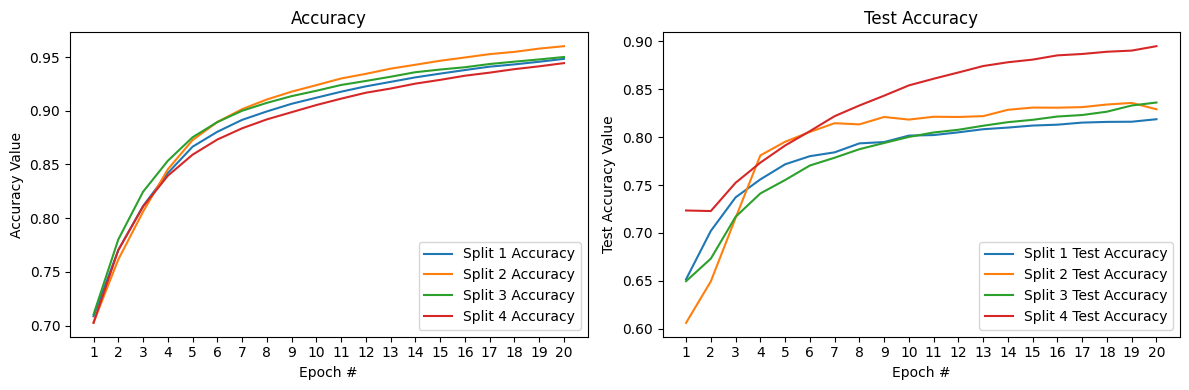

In [20]:
plot_metrics(all_histories, ["accuracy" , "val_accuracy"] )

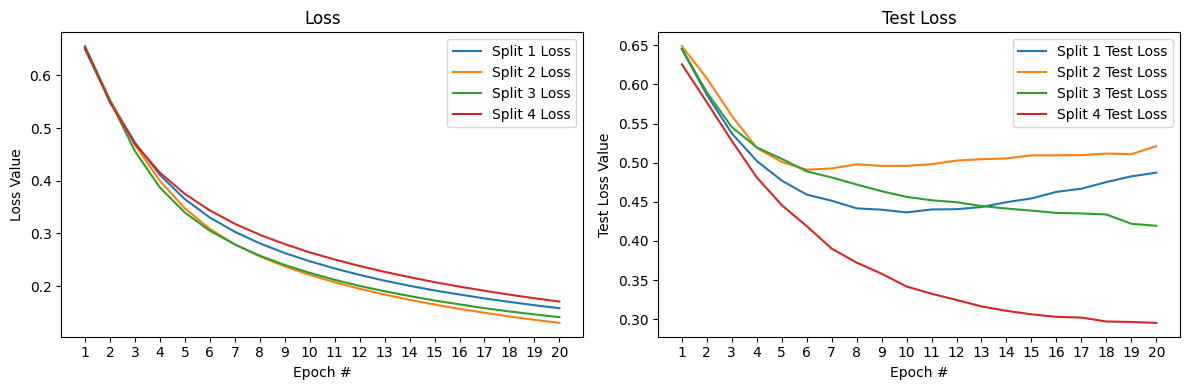

In [8]:
plot_metrics(all_histories, ["loss" , "val_loss"] )

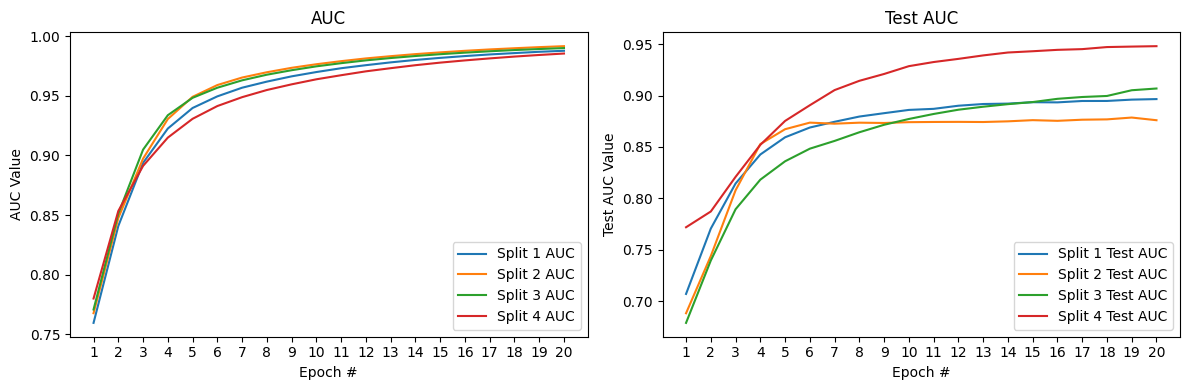

In [24]:
plot_metrics(all_histories, ["auc" , "val_auc"] )

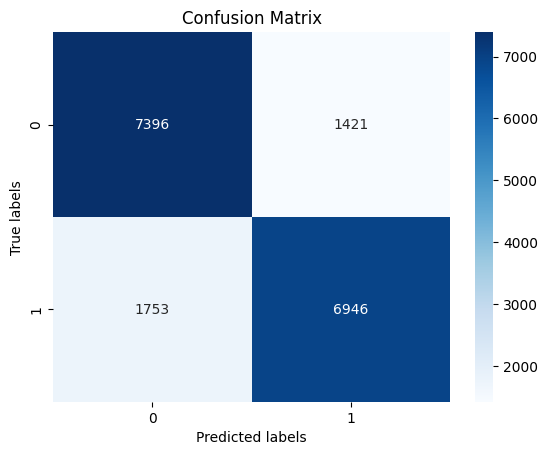

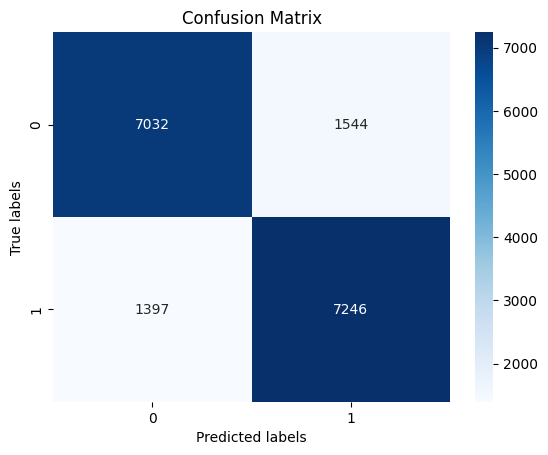

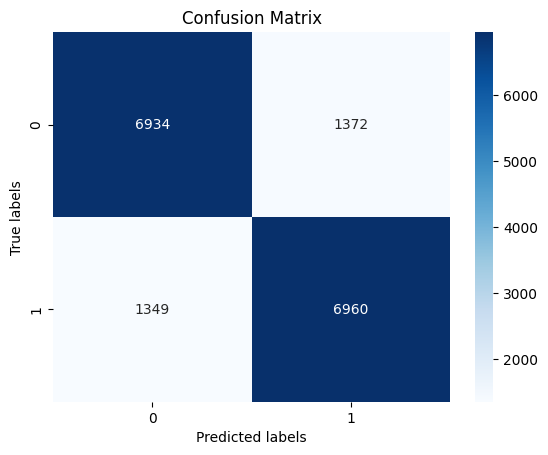

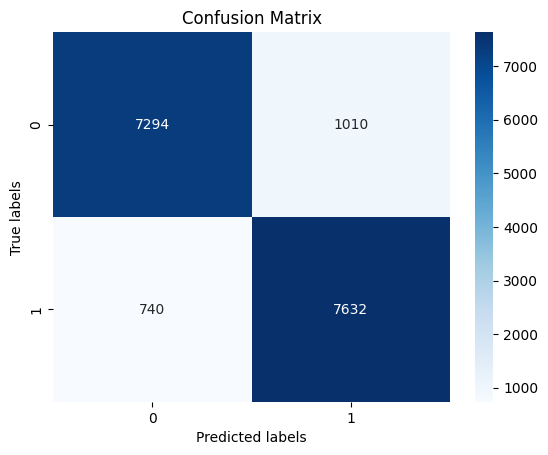

In [32]:
for i in range(4):
    plot_confusion_matrix(all_y_true[i], all_y_pred_binary[i] , [0 , 1])

In [33]:
for i in range(4):
    print(classification_report(all_y_true[i], all_y_pred_binary[i]))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82      8817
           1       0.83      0.80      0.81      8699

    accuracy                           0.82     17516
   macro avg       0.82      0.82      0.82     17516
weighted avg       0.82      0.82      0.82     17516

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      8576
           1       0.82      0.84      0.83      8643

    accuracy                           0.83     17219
   macro avg       0.83      0.83      0.83     17219
weighted avg       0.83      0.83      0.83     17219

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      8306
           1       0.84      0.84      0.84      8309

    accuracy                           0.84     16615
   macro avg       0.84      0.84      0.84     16615
weighted avg       0.84      0.84      0.84     16615

              preci

# low quality - vgg16 - unfreeze 1000

In [14]:
def create_model(size = (224 , 224 , 3)):
    
    vgg16_base = VGG16(weights='imagenet', include_top=True, input_shape= size)

    for layer in vgg16_base.layers[:-1]:
        layer.trainable = False

    model = Sequential()
    model.add(vgg16_base)
    #model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    #model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy' ,Precision() , Recall() , AUC()])

    return model

In [ ]:
num_folds = 4
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

Epochs = 5
batch_size = 64
epoch_list = list(range(1, Epochs + 1))
all_histories = []
result_train = []
result_test = []
all_y_true = []
all_y_pred_binary = []

#these two variables are used for kfold on persons. 
persons = np.arange(64)
labels = np.concatenate((np.ones(32), np.zeros(32)))


for fold_index, (train_index_p, test_index_p) in enumerate(kf.split(persons , labels)):
    
    K.clear_session()
    gc.collect()
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint_path = f"vgg_unfreeze_LQ_fold_{fold_index}.keras"
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    model = create_model((224 , 224 , 3)) 
    
    train_generator = MyDataGenerator(shuffled_low_real, train_index_p , batch_size)
    val_generator = MyDataGenerator(shuffled_low_real, test_index_p, batch_size )

    history = model.fit(train_generator, epochs=Epochs,validation_data=val_generator , callbacks = [checkpoint])

    all_histories.append(history.history)
    
    
    train_results = model.evaluate(train_generator)
    print("Metrics on train:")
    print(train_results)
    result_train.append(train_results)
        
    test_results = model.evaluate(val_generator)
    print("Metrics on test:")
    print(test_results)
    result_test.append(test_results)
    
    
    y_true =  val_generator.get_true_labels()
    y_pred = model.predict(val_generator)
    y_pred_binary = (y_pred > 0.5).astype(int) 
    all_y_pred_binary.append(y_pred_binary)
    all_y_true.append(y_true)

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/5


I0000 00:00:1716749656.246375     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716749656.269218     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


233/790 ━━━━━━━━━━━━━━━━━━━━ 10:01 1s/step - accuracy: 0.8376 - auc: 0.8960 - loss: 0.6409 - precision: 0.8796 - recall: 0.7687

W0000 00:00:1716749906.894417     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


790/790 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9173 - auc: 0.9601 - loss: 0.4889 - precision: 0.9361 - recall: 0.8903

W0000 00:00:1716750487.688963     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.93486, saving model to vgg_unfreeze_LQ_fold_0.keras


W0000 00:00:1716750825.137236     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


790/790 ━━━━━━━━━━━━━━━━━━━━ 1241s 1s/step - accuracy: 0.9174 - auc: 0.9601 - loss: 0.4887 - precision: 0.9361 - recall: 0.8904 - val_accuracy: 0.9349 - val_auc: 0.9835 - val_loss: 0.2028 - val_precision: 0.9575 - val_recall: 0.9092
Epoch 2/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9976 - auc: 0.9999 - loss: 0.0582 - precision: 0.9974 - recall: 0.9976
Epoch 2: val_accuracy improved from 0.93486 to 0.93754, saving model to vgg_unfreeze_LQ_fold_0.keras
790/790 ━━━━━━━━━━━━━━━━━━━━ 455s 572ms/step - accuracy: 0.9976 - auc: 0.9999 - loss: 0.0582 - precision: 0.9974 - recall: 0.9976 - val_accuracy: 0.9375 - val_auc: 0.9835 - val_loss: 0.1773 - val_precision: 0.9508 - val_recall: 0.9219
Epoch 3/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9992 - auc: 1.0000 - loss: 0.0150 - precision: 0.9988 - recall: 0.9997
Epoch 3: val_accuracy did not improve from 0.93754
790/790 ━━━━━━━━━━━━━━━━━━━━ 419s 526ms/step - accuracy: 0.9992 - auc: 1.0000 - loss: 0.0150 - precision

W0000 00:00:1716752891.793245     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Metrics on train:
[0.0042322492226958275, 0.9989705085754395, 0.9999800324440002, 0.9979507923126221, 1.0]
274/274 ━━━━━━━━━━━━━━━━━━━━ 102s 371ms/step - accuracy: 0.9274 - auc: 0.9752 - loss: 0.2497 - precision: 0.9088 - recall: 0.9491
Metrics on test:
[0.2544271945953369, 0.9265813827514648, 0.9748448133468628, 0.9085198044776917, 0.9475801587104797]
  1/274 ━━━━━━━━━━━━━━━━━━━━ 5:05 1s/step

W0000 00:00:1716752995.635472     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


274/274 ━━━━━━━━━━━━━━━━━━━━ 98s 355ms/step


W0000 00:00:1716753092.672325     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/5


W0000 00:00:1716753102.049303     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


385/794 ━━━━━━━━━━━━━━━━━━━━ 2:32 374ms/step - accuracy: 0.8623 - auc: 0.9384 - loss: 0.6015 - precision: 0.8171 - recall: 0.9702

W0000 00:00:1716753295.445431     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9133 - auc: 0.9668 - loss: 0.4991 - precision: 0.8815 - recall: 0.9768

W0000 00:00:1716753458.465300     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.86707, saving model to vgg_unfreeze_LQ_fold_1.keras


W0000 00:00:1716753575.984397     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


794/794 ━━━━━━━━━━━━━━━━━━━━ 482s 600ms/step - accuracy: 0.9134 - auc: 0.9669 - loss: 0.4989 - precision: 0.8816 - recall: 0.9769 - val_accuracy: 0.8671 - val_auc: 0.9326 - val_loss: 0.3412 - val_precision: 0.8370 - val_recall: 0.9130
Epoch 2/5
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9977 - auc: 0.9999 - loss: 0.0612 - precision: 0.9975 - recall: 0.9979
Epoch 2: val_accuracy did not improve from 0.86707
794/794 ━━━━━━━━━━━━━━━━━━━━ 413s 516ms/step - accuracy: 0.9977 - auc: 0.9999 - loss: 0.0611 - precision: 0.9975 - recall: 0.9979 - val_accuracy: 0.8571 - val_auc: 0.9215 - val_loss: 0.4196 - val_precision: 0.8365 - val_recall: 0.8890
Epoch 3/5
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9991 - auc: 1.0000 - loss: 0.0154 - precision: 0.9992 - recall: 0.9990
Epoch 3: val_accuracy did not improve from 0.86707
794/794 ━━━━━━━━━━━━━━━━━━━━ 403s 503ms/step - accuracy: 0.9991 - auc: 1.0000 - loss: 0.0154 - precision: 0.9992 - recall: 0.9990 - val_accuracy: 0.8542

W0000 00:00:1716755503.416601     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


794/794 ━━━━━━━━━━━━━━━━━━━━ 301s 379ms/step - accuracy: 0.9997 - auc: 1.0000 - loss: 0.0026 - precision: 1.0000 - recall: 0.9994
Metrics on train:
[0.002634731587022543, 0.9997244477272034, 1.0, 1.0, 0.9994483590126038]
270/270 ━━━━━━━━━━━━━━━━━━━━ 101s 374ms/step - accuracy: 0.8224 - auc: 0.8956 - loss: 0.7137 - precision: 0.8731 - recall: 0.7593
Metrics on test:
[0.7158873081207275, 0.8222893476486206, 0.8967348337173462, 0.8699800968170166, 0.7594585418701172]
  1/270 ━━━━━━━━━━━━━━━━━━━━ 4:39 1s/step

W0000 00:00:1716755606.952102     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


270/270 ━━━━━━━━━━━━━━━━━━━━ 98s 362ms/step


W0000 00:00:1716755704.245502     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/5


W0000 00:00:1716755713.644660     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


737/804 ━━━━━━━━━━━━━━━━━━━━ 27s 409ms/step - accuracy: 0.9321 - auc: 0.9678 - loss: 0.5100 - precision: 0.9271 - recall: 0.9370

W0000 00:00:1716756015.127955     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


804/804 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9355 - auc: 0.9700 - loss: 0.4955 - precision: 0.9306 - recall: 0.9403

W0000 00:00:1716756042.401708     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.91574, saving model to vgg_unfreeze_LQ_fold_2.keras


W0000 00:00:1716756188.150520     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


804/804 ━━━━━━━━━━━━━━━━━━━━ 483s 593ms/step - accuracy: 0.9355 - auc: 0.9700 - loss: 0.4953 - precision: 0.9307 - recall: 0.9403 - val_accuracy: 0.9157 - val_auc: 0.9708 - val_loss: 0.2438 - val_precision: 0.8925 - val_recall: 0.9454
Epoch 2/5
804/804 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.9973 - auc: 0.9999 - loss: 0.0636 - precision: 0.9970 - recall: 0.9975
Epoch 2: val_accuracy improved from 0.91574 to 0.93289, saving model to vgg_unfreeze_LQ_fold_2.keras
804/804 ━━━━━━━━━━━━━━━━━━━━ 406s 501ms/step - accuracy: 0.9973 - auc: 0.9999 - loss: 0.0635 - precision: 0.9970 - recall: 0.9975 - val_accuracy: 0.9329 - val_auc: 0.9778 - val_loss: 0.1914 - val_precision: 0.9115 - val_recall: 0.9590
Epoch 3/5
804/804 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9991 - auc: 1.0000 - loss: 0.0156 - precision: 0.9987 - recall: 0.9995
Epoch 3: val_accuracy did not improve from 0.93289
804/804 ━━━━━━━━━━━━━━━━━━━━ 398s 490ms/step - accuracy: 0.9991 - auc: 1.0000 - loss: 0.0156 - precisi

W0000 00:00:1716758129.025027     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Metrics on train:
[0.0018806385342031717, 0.9999610781669617, 0.9999801516532898, 0.9999222159385681, 1.0]
260/260 ━━━━━━━━━━━━━━━━━━━━ 108s 415ms/step - accuracy: 0.9440 - auc: 0.9792 - loss: 0.1985 - precision: 0.9453 - recall: 0.9411
Metrics on test:
[0.2016398012638092, 0.941257894039154, 0.9795400500297546, 0.9440474510192871, 0.9381393790245056]
  1/260 ━━━━━━━━━━━━━━━━━━━━ 4:19 1s/step

W0000 00:00:1716758239.185849     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


260/260 ━━━━━━━━━━━━━━━━━━━━ 93s 355ms/step


W0000 00:00:1716758331.214034     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/5


W0000 00:00:1716758340.779914     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 88/803 ━━━━━━━━━━━━━━━━━━━━ 7:48 655ms/step - accuracy: 0.7245 - auc: 0.7779 - loss: 0.6812 - precision: 0.7739 - recall: 0.6114

W0000 00:00:1716758397.940922     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


803/803 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.9122 - auc: 0.9573 - loss: 0.4979 - precision: 0.9311 - recall: 0.8836

W0000 00:00:1716758687.187352     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.96390, saving model to vgg_unfreeze_LQ_fold_3.keras


W0000 00:00:1716758829.586262     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


803/803 ━━━━━━━━━━━━━━━━━━━━ 497s 612ms/step - accuracy: 0.9122 - auc: 0.9574 - loss: 0.4977 - precision: 0.9312 - recall: 0.8837 - val_accuracy: 0.9639 - val_auc: 0.9934 - val_loss: 0.1507 - val_precision: 0.9722 - val_recall: 0.9554
Epoch 2/5
803/803 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.9976 - auc: 0.9999 - loss: 0.0569 - precision: 0.9967 - recall: 0.9985
Epoch 2: val_accuracy did not improve from 0.96390
803/803 ━━━━━━━━━━━━━━━━━━━━ 436s 538ms/step - accuracy: 0.9976 - auc: 0.9999 - loss: 0.0569 - precision: 0.9967 - recall: 0.9985 - val_accuracy: 0.9601 - val_auc: 0.9931 - val_loss: 0.1102 - val_precision: 0.9693 - val_recall: 0.9505
Epoch 3/5
803/803 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.9992 - auc: 1.0000 - loss: 0.0145 - precision: 0.9989 - recall: 0.9994
Epoch 3: val_accuracy did not improve from 0.96390
803/803 ━━━━━━━━━━━━━━━━━━━━ 428s 530ms/step - accuracy: 0.9992 - auc: 1.0000 - loss: 0.0145 - precision: 0.9989 - recall: 0.9994 - val_accuracy: 0.9494

W0000 00:00:1716760842.859313     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Metrics on train:
[0.0019923262298107147, 0.9998441934585571, 0.9999799132347107, 0.9999220371246338, 0.9997661113739014]
261/261 ━━━━━━━━━━━━━━━━━━━━ 97s 370ms/step - accuracy: 0.9343 - auc: 0.9845 - loss: 0.2061 - precision: 0.9681 - recall: 0.8991
Metrics on test:
[0.20105919241905212, 0.9384145140647888, 0.9848302006721497, 0.9686104655265808, 0.9067128300666809]
  1/261 ━━━━━━━━━━━━━━━━━━━━ 4:43 1s/step

W0000 00:00:1716760941.741224     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


234/261 ━━━━━━━━━━━━━━━━━━━━ 9s 351ms/step

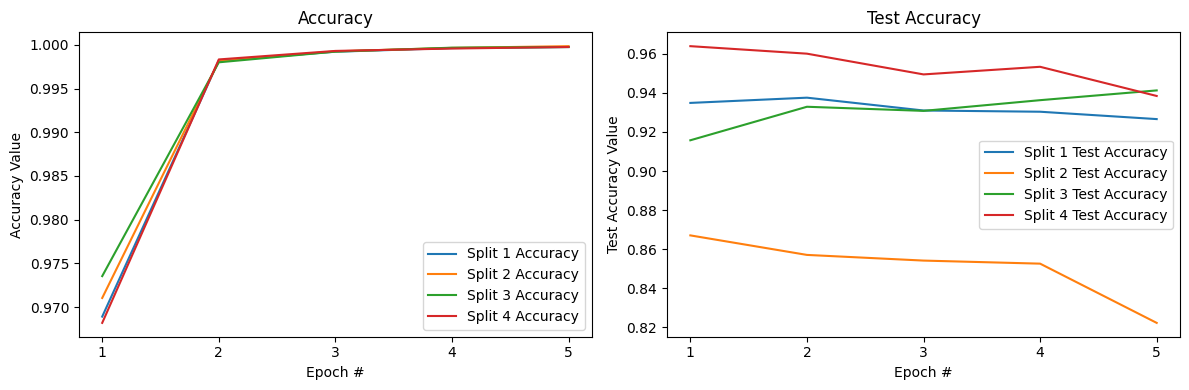

In [19]:
plot_metrics(all_histories, ["accuracy" , "val_accuracy"] )

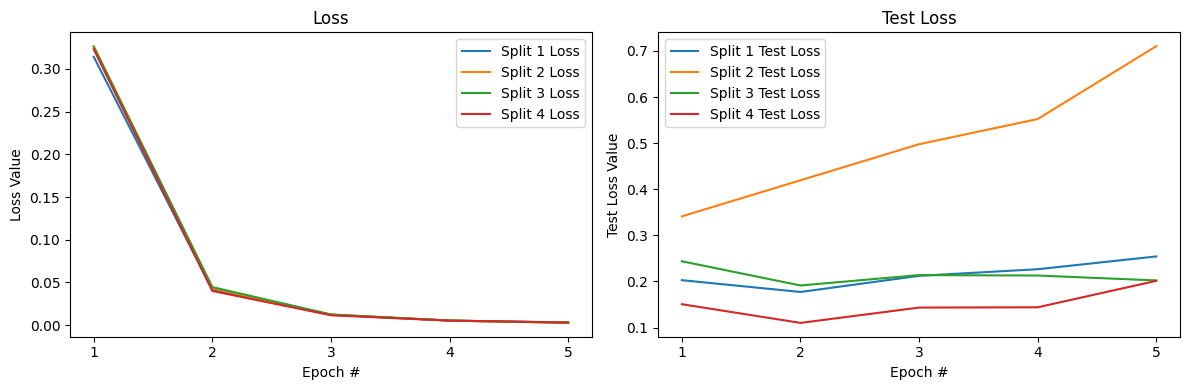

In [20]:
plot_metrics(all_histories, ["loss" , "val_loss"] )

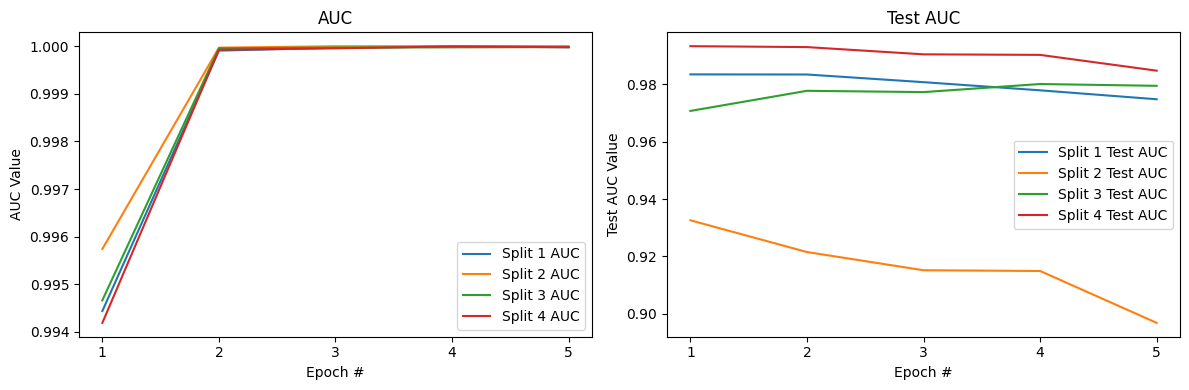

In [21]:
plot_metrics(all_histories, ["auc" , "val_auc"] )

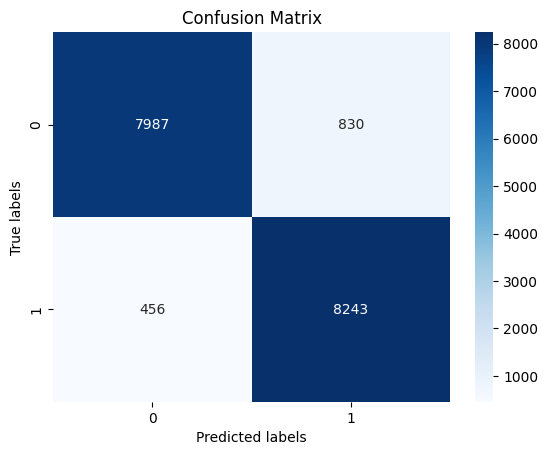

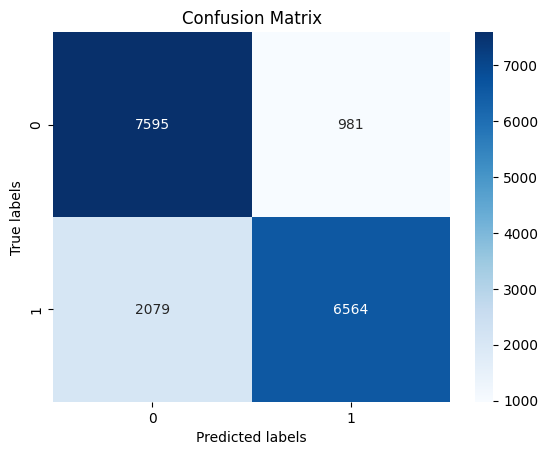

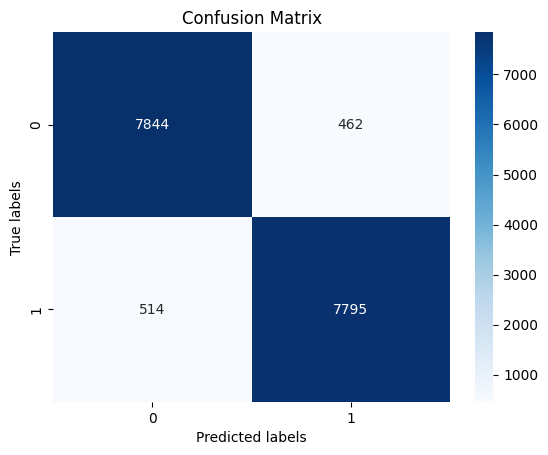

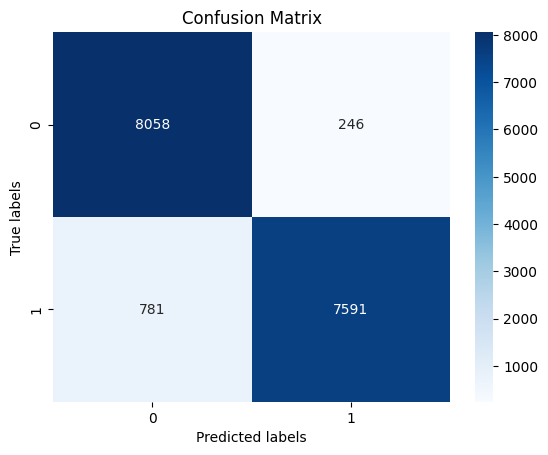

In [27]:
for i in range(4):
    plot_confusion_matrix(all_y_true[i], all_y_pred_binary[i] , [0 , 1])

In [28]:
for i in range(4):
    print(classification_report(all_y_true[i], all_y_pred_binary[i]))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      8817
           1       0.91      0.95      0.93      8699

    accuracy                           0.93     17516
   macro avg       0.93      0.93      0.93     17516
weighted avg       0.93      0.93      0.93     17516

              precision    recall  f1-score   support

           0       0.79      0.89      0.83      8576
           1       0.87      0.76      0.81      8643

    accuracy                           0.82     17219
   macro avg       0.83      0.82      0.82     17219
weighted avg       0.83      0.82      0.82     17219

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      8306
           1       0.94      0.94      0.94      8309

    accuracy                           0.94     16615
   macro avg       0.94      0.94      0.94     16615
weighted avg       0.94      0.94      0.94     16615

              preci

# low quality - resnet50 - unfreeze 1000 - before - all_histories not available

In [17]:
def create_model_resnet(size = (224 , 224 , 3)):
    #with strategy.scope():
    vgg16_base = ResNet50(weights='imagenet', include_top=True, input_shape= size)

    for layer in vgg16_base.layers[:-1]: 
        layer.trainable = False

    model = Sequential()
    model.add(vgg16_base)
        #model.add(Flatten())
    model.add(Dense(256, activation='relu'))
        #model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy' ,Precision() , Recall() , AUC()])

    return model

In [22]:
num_folds = 4
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

Epochs = 5 
batch_size = 64
epoch_list = list(range(1, Epochs + 1))
all_histories = []
result_train = []
result_test = []
all_y_true = []
all_y_pred_binary = []

#these two variables are used for kfold on persons. 
persons = np.arange(64)
labels = np.concatenate((np.ones(32), np.zeros(32)))


for fold_index, (train_index_p, test_index_p) in enumerate(kf.split(persons , labels)):

    K.clear_session()
    gc.collect()
    print(f"Fold: {fold_index + 1}")
    model = create_model_resnet((224 , 224 , 3)) 
    
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    train_generator = MyDataGenerator(shuffled_low_real, train_index_p , batch_size)
    val_generator = MyDataGenerator(shuffled_low_real, test_index_p, batch_size )

    history = model.fit(train_generator, epochs=Epochs,validation_data=val_generator, 
                        callbacks=[early_stopping])

    all_histories.append(history.history)
    
    
    train_results = model.evaluate(train_generator)
    print("Metrics on train:")
    print(train_results)
    result_train.append(train_results)
        
    test_results = model.evaluate(val_generator)
    print("Metrics on test:")
    print(test_results)
    result_test.append(test_results)
    
    
    y_true =  val_generator.get_true_labels()
    y_pred = model.predict(val_generator)
    y_pred_binary = (y_pred > 0.5).astype(int) 
    all_y_pred_binary.append(y_pred_binary)
    all_y_true.append(y_true)

Fold: 1
102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5


I0000 00:00:1713695916.294685     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713695916.342938     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


402/790 ━━━━━━━━━━━━━━━━━━━━ 3:52 600ms/step - accuracy: 0.8179 - auc: 0.8809 - loss: 0.6245 - precision: 0.8079 - recall: 0.8490

W0000 00:00:1713696157.121985     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


790/790 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.8775 - auc: 0.9327 - loss: 0.5254 - precision: 0.8705 - recall: 0.8955

W0000 00:00:1713696386.056170     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713696554.246246     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


790/790 ━━━━━━━━━━━━━━━━━━━━ 666s 809ms/step - accuracy: 0.8776 - auc: 0.9328 - loss: 0.5251 - precision: 0.8707 - recall: 0.8956 - val_accuracy: 0.9492 - val_auc: 0.9931 - val_loss: 0.1718 - val_precision: 0.9609 - val_recall: 0.9359
Epoch 2/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 340s 427ms/step - accuracy: 0.9989 - auc: 1.0000 - loss: 0.0568 - precision: 0.9990 - recall: 0.9989 - val_accuracy: 0.9589 - val_auc: 0.9964 - val_loss: 0.0998 - val_precision: 0.9792 - val_recall: 0.9371
Epoch 3/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 312s 392ms/step - accuracy: 0.9999 - auc: 1.0000 - loss: 0.0133 - precision: 0.9998 - recall: 1.0000 - val_accuracy: 0.9633 - val_auc: 0.9969 - val_loss: 0.0867 - val_precision: 0.9792 - val_recall: 0.9463
Epoch 4/5
790/790 ━━━━━━━━━━━━━━━━━━━━ 309s 388ms/step - accuracy: 0.9999 - auc: 1.0000 - loss: 0.0052 - precision: 0.9999 - recall: 1.0000 - val_accuracy: 0.9629 - val_auc: 0.9973 - val_loss: 0.0943 - val_precision: 0.9876 - val_recall: 0.9371
Epoch 5/5
790/790 ━━━━━━━━━━━━

W0000 00:00:1713698046.464484     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Metrics on train:
[0.001532208640128374, 0.9999802112579346, 1.0, 0.9999605417251587, 1.0]
274/274 ━━━━━━━━━━━━━━━━━━━━ 77s 279ms/step - accuracy: 0.9677 - auc: 0.9973 - loss: 0.0836 - precision: 0.9838 - recall: 0.9498
Metrics on test:
[0.08250372856855392, 0.9672870635986328, 0.9975019097328186, 0.9835753440856934, 0.9499942660331726]
  2/274 ━━━━━━━━━━━━━━━━━━━━ 47s 174ms/step

W0000 00:00:1713698127.913336     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


274/274 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step


W0000 00:00:1713698205.140121     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Fold: 2
Epoch 1/5
  1/794 ━━━━━━━━━━━━━━━━━━━━ 2:56:53 13s/step - accuracy: 0.6719 - auc_1: 0.5880 - loss: 0.6921 - precision_1: 0.6786 - recall_1: 0.6129

W0000 00:00:1713698220.030590     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


122/794 ━━━━━━━━━━━━━━━━━━━━ 4:28 399ms/step - accuracy: 0.7221 - auc_1: 0.7905 - loss: 0.6815 - precision_1: 0.7649 - recall_1: 0.6282

W0000 00:00:1713698268.315372     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.8904 - auc_1: 0.9462 - loss: 0.5143 - precision_1: 0.9150 - recall_1: 0.8536

W0000 00:00:1713698473.568316     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713698566.542684     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


794/794 ━━━━━━━━━━━━━━━━━━━━ 360s 437ms/step - accuracy: 0.8905 - auc_1: 0.9463 - loss: 0.5140 - precision_1: 0.9151 - recall_1: 0.8537 - val_accuracy: 0.9578 - val_auc_1: 0.9957 - val_loss: 0.1552 - val_precision_1: 0.9293 - val_recall_1: 0.9913
Epoch 2/5
794/794 ━━━━━━━━━━━━━━━━━━━━ 330s 413ms/step - accuracy: 0.9996 - auc_1: 1.0000 - loss: 0.0407 - precision_1: 0.9995 - recall_1: 0.9997 - val_accuracy: 0.9724 - val_auc_1: 0.9981 - val_loss: 0.0790 - val_precision_1: 0.9515 - val_recall_1: 0.9958
Epoch 3/5
794/794 ━━━━━━━━━━━━━━━━━━━━ 330s 413ms/step - accuracy: 0.9999 - auc_1: 1.0000 - loss: 0.0094 - precision_1: 0.9999 - recall_1: 1.0000 - val_accuracy: 0.9772 - val_auc_1: 0.9985 - val_loss: 0.0616 - val_precision_1: 0.9615 - val_recall_1: 0.9944
Epoch 4/5
794/794 ━━━━━━━━━━━━━━━━━━━━ 326s 408ms/step - accuracy: 1.0000 - auc_1: 1.0000 - loss: 0.0037 - precision_1: 1.0000 - recall_1: 1.0000 - val_accuracy: 0.9737 - val_auc_1: 0.9985 - val_loss: 0.0697 - val_precision_1: 0.9524 - val

W0000 00:00:1713700132.687294     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Metrics on train:
[0.004410716239362955, 0.9999803304672241, 1.0, 1.0, 0.9999606013298035]
270/270 ━━━━━━━━━━━━━━━━━━━━ 80s 297ms/step - accuracy: 0.9758 - auc_1: 0.9984 - loss: 0.0640 - precision_1: 0.9594 - recall_1: 0.9936
Metrics on test:
[0.06220922991633415, 0.977234423160553, 0.9984760284423828, 0.9615169763565063, 0.9944463968276978]
  2/270 ━━━━━━━━━━━━━━━━━━━━ 42s 158ms/step

W0000 00:00:1713700217.668383     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


270/270 ━━━━━━━━━━━━━━━━━━━━ 82s 291ms/step


W0000 00:00:1713700295.964072     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Fold: 3
Epoch 1/5
  1/804 ━━━━━━━━━━━━━━━━━━━━ 3:05:44 14s/step - accuracy: 0.6094 - auc_2: 0.6091 - loss: 0.6923 - precision_2: 0.7037 - recall_2: 0.5278

W0000 00:00:1713700311.343803     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


210/804 ━━━━━━━━━━━━━━━━━━━━ 3:15 329ms/step - accuracy: 0.7744 - auc_2: 0.8256 - loss: 0.6711 - precision_2: 0.8194 - recall_2: 0.7110

W0000 00:00:1713700380.339699     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


804/804 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.8916 - auc_2: 0.9411 - loss: 0.5192 - precision_2: 0.9216 - recall_2: 0.8544

W0000 00:00:1713700571.560056     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713700670.631603     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


804/804 ━━━━━━━━━━━━━━━━━━━━ 373s 448ms/step - accuracy: 0.8916 - auc_2: 0.9412 - loss: 0.5190 - precision_2: 0.9216 - recall_2: 0.8545 - val_accuracy: 0.9736 - val_auc_2: 0.9959 - val_loss: 0.1291 - val_precision_2: 0.9541 - val_recall_2: 0.9951
Epoch 2/5
804/804 ━━━━━━━━━━━━━━━━━━━━ 336s 415ms/step - accuracy: 0.9994 - auc_2: 1.0000 - loss: 0.0469 - precision_2: 0.9993 - recall_2: 0.9995 - val_accuracy: 0.9834 - val_auc_2: 0.9972 - val_loss: 0.0627 - val_precision_2: 0.9719 - val_recall_2: 0.9957
Epoch 3/5
804/804 ━━━━━━━━━━━━━━━━━━━━ 322s 397ms/step - accuracy: 0.9999 - auc_2: 1.0000 - loss: 0.0110 - precision_2: 0.9997 - recall_2: 1.0000 - val_accuracy: 0.9870 - val_auc_2: 0.9977 - val_loss: 0.0489 - val_precision_2: 0.9788 - val_recall_2: 0.9955
Epoch 4/5
804/804 ━━━━━━━━━━━━━━━━━━━━ 315s 389ms/step - accuracy: 1.0000 - auc_2: 1.0000 - loss: 0.0042 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 0.9877 - val_auc_2: 0.9967 - val_loss: 0.0484 - val_precision_2: 0.9779 - val

W0000 00:00:1713702191.299972     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Metrics on train:
[0.002385558560490608, 0.9999610781669617, 1.0, 0.9999222159385681, 1.0]
260/260 ━━━━━━━━━━━━━━━━━━━━ 73s 280ms/step - accuracy: 0.9869 - auc_2: 0.9968 - loss: 0.0516 - precision_2: 0.9764 - recall_2: 0.9980
Metrics on test:
[0.048395492136478424, 0.9877219200134277, 0.9967222213745117, 0.9779455065727234, 0.9979540109634399]
  2/260 ━━━━━━━━━━━━━━━━━━━━ 39s 155ms/step

W0000 00:00:1713702268.982936     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


260/260 ━━━━━━━━━━━━━━━━━━━━ 77s 284ms/step


W0000 00:00:1713702342.505576     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Fold: 4
Epoch 1/5
  1/803 ━━━━━━━━━━━━━━━━━━━━ 2:55:45 13s/step - accuracy: 0.5156 - auc_3: 0.5216 - loss: 0.6931 - precision_3: 0.4667 - recall_3: 0.2333

W0000 00:00:1713702357.105726     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


473/803 ━━━━━━━━━━━━━━━━━━━━ 1:42 311ms/step - accuracy: 0.8307 - auc_3: 0.9117 - loss: 0.6121 - precision_3: 0.9094 - recall_3: 0.7139

W0000 00:00:1713702504.057295     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


803/803 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.8791 - auc_3: 0.9448 - loss: 0.5359 - precision_3: 0.9357 - recall_3: 0.7992

W0000 00:00:1713702612.310454     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713702710.566075     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


803/803 ━━━━━━━━━━━━━━━━━━━━ 367s 441ms/step - accuracy: 0.8792 - auc_3: 0.9449 - loss: 0.5357 - precision_3: 0.9357 - recall_3: 0.7994 - val_accuracy: 0.9780 - val_auc_3: 0.9988 - val_loss: 0.1530 - val_precision_3: 0.9968 - val_recall_3: 0.9593
Epoch 2/5
803/803 ━━━━━━━━━━━━━━━━━━━━ 324s 401ms/step - accuracy: 0.9996 - auc_3: 1.0000 - loss: 0.0703 - precision_3: 0.9996 - recall_3: 0.9997 - val_accuracy: 0.9887 - val_auc_3: 0.9997 - val_loss: 0.0523 - val_precision_3: 0.9970 - val_recall_3: 0.9804
Epoch 3/5
803/803 ━━━━━━━━━━━━━━━━━━━━ 315s 389ms/step - accuracy: 0.9999 - auc_3: 1.0000 - loss: 0.0161 - precision_3: 0.9999 - recall_3: 1.0000 - val_accuracy: 0.9857 - val_auc_3: 0.9998 - val_loss: 0.0422 - val_precision_3: 0.9984 - val_recall_3: 0.9731
Epoch 4/5
803/803 ━━━━━━━━━━━━━━━━━━━━ 306s 378ms/step - accuracy: 0.9999 - auc_3: 1.0000 - loss: 0.0062 - precision_3: 0.9998 - recall_3: 1.0000 - val_accuracy: 0.9878 - val_auc_3: 0.9998 - val_loss: 0.0333 - val_precision_3: 0.9983 - val

W0000 00:00:1713704201.437575     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Metrics on train:
[0.0034339125268161297, 0.9999610781669617, 1.0, 0.9999220371246338, 1.0]
261/261 ━━━━━━━━━━━━━━━━━━━━ 72s 276ms/step - accuracy: 0.9881 - auc_3: 0.9998 - loss: 0.0333 - precision_3: 0.9988 - recall_3: 0.9771
Metrics on test:
[0.03335500881075859, 0.9877668619155884, 0.9998093843460083, 0.9982918500900269, 0.9773052930831909]
  2/261 ━━━━━━━━━━━━━━━━━━━━ 45s 174ms/step

W0000 00:00:1713704278.273394     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


261/261 ━━━━━━━━━━━━━━━━━━━━ 76s 278ms/step


W0000 00:00:1713704350.510640     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


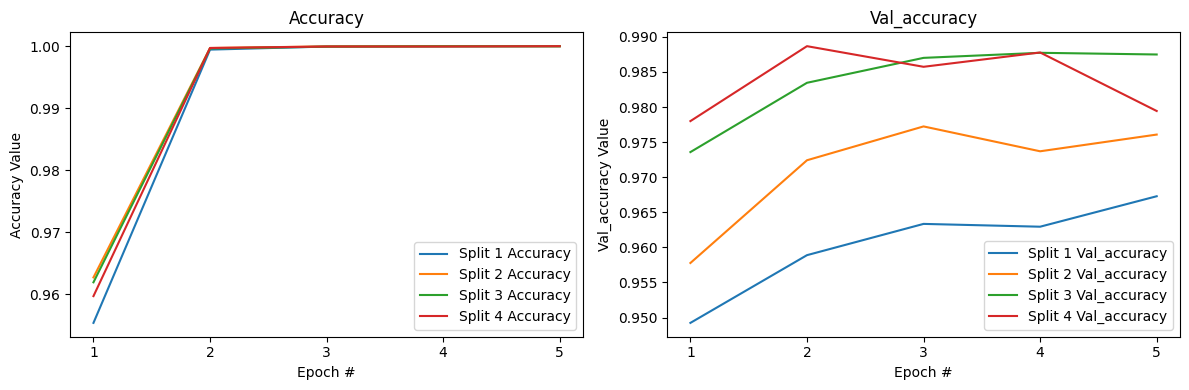

In [24]:
plot_metrics(all_histories, ["accuracy" , "val_accuracy"] )

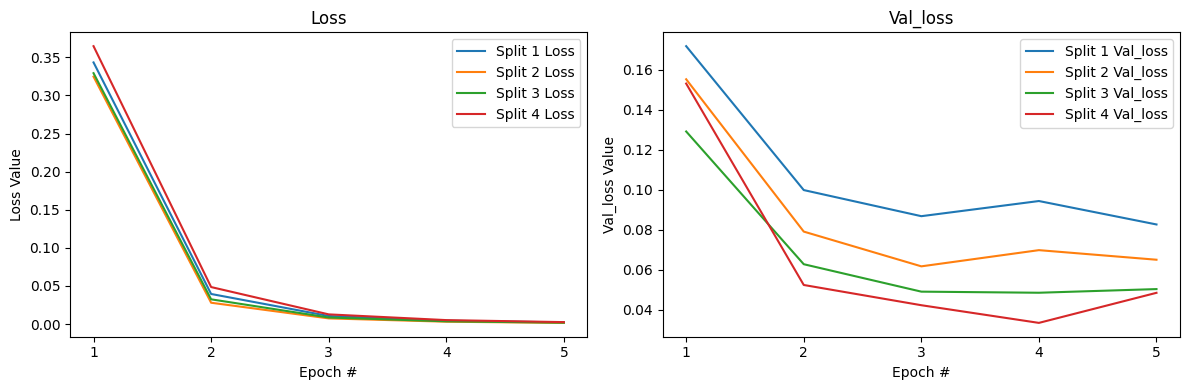

In [25]:
plot_metrics(all_histories, ["loss" , "val_loss"] )

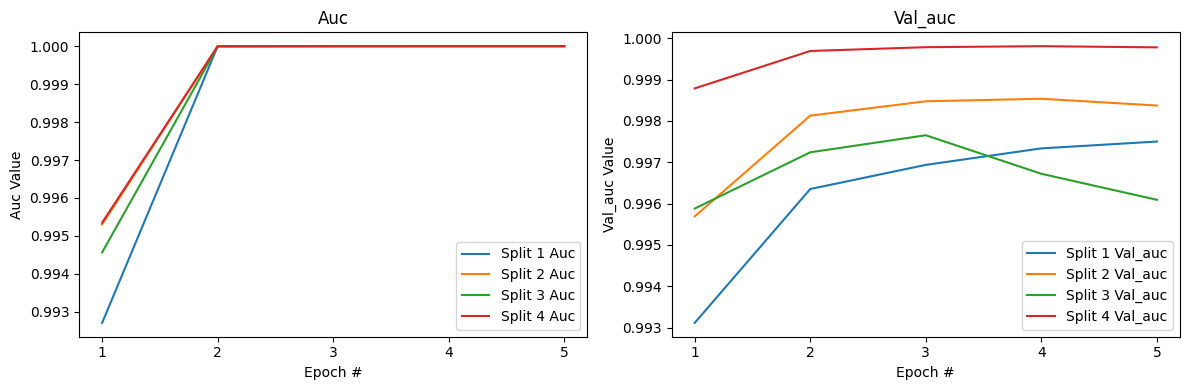

In [33]:
plot_metrics(all_histories, ["auc" , "val_auc"] )

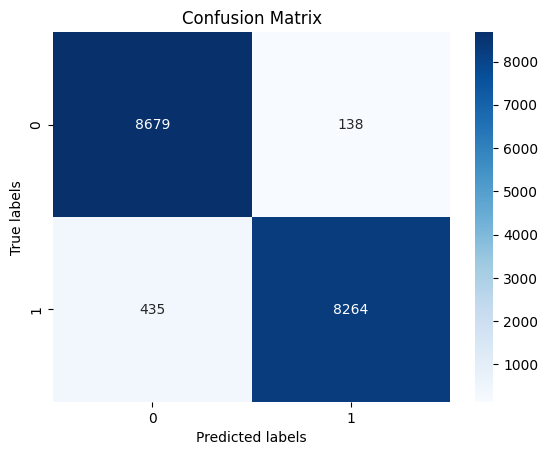

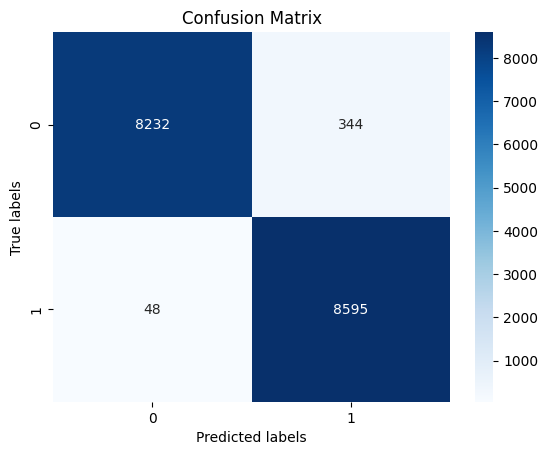

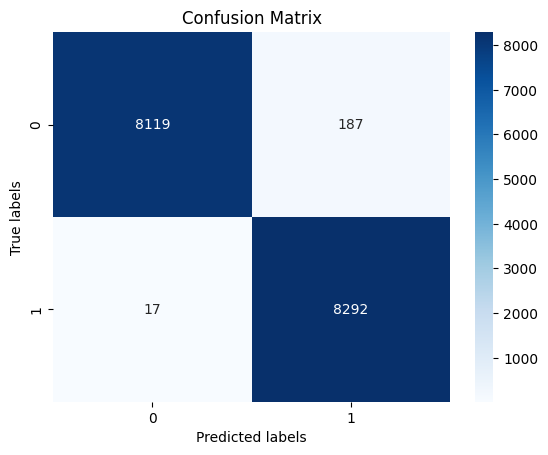

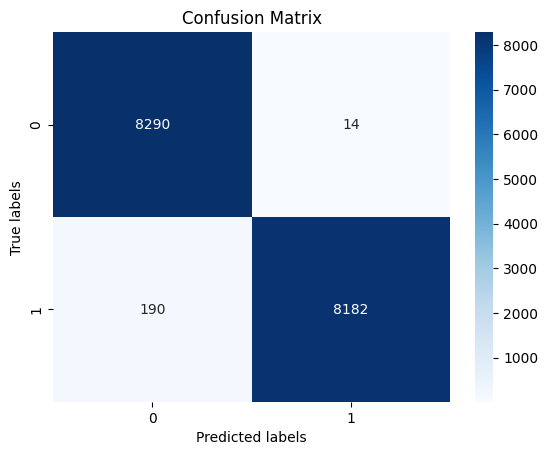

In [39]:
for i in range(len(all_y_true)):
    plot_confusion_matrix(all_y_true[i], all_y_pred_binary[i] , [0 , 1])

# high quality - vgg16 - freeze

In [11]:
def create_model(size = (224 , 224 , 3)):
    #with strategy.scope():
    vgg16_base = VGG16(weights='imagenet', include_top=True, input_shape= size)

    for layer in vgg16_base.layers:
        layer.trainable = False

    model = Sequential()
    model.add(vgg16_base)
        #model.add(Flatten())
    model.add(Dense(256, activation='relu'))
        #model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy' ,Precision() , Recall() , AUC()])

    return model

In [12]:
num_folds = 4
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

Epochs = 20
batch_size = 64
epoch_list = list(range(1, Epochs + 1))
all_histories = []
result_train = []
result_test = []
all_y_true = []
all_y_pred_binary = []

#these two variables are used for kfold on persons. 
persons = np.arange(64)
labels = np.concatenate((np.ones(32), np.zeros(32)))


for fold_index, (train_index_p, test_index_p) in enumerate(kf.split(persons , labels)):
    
    K.clear_session()
    gc.collect()
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint_path = f"vgg_freeze__LQ_fold_{fold_index}.keras"
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    model = create_model((224 , 224 , 3)) 
    
    train_generator = MyDataGenerator(shuffled_high_real, train_index_p , batch_size)
    val_generator = MyDataGenerator(shuffled_high_real, test_index_p, batch_size )

    history = model.fit(train_generator, epochs=Epochs,validation_data=val_generator , callbacks = [checkpoint])

    all_histories.append(history.history)
    
    
    train_results = model.evaluate(train_generator)
    print("Metrics on train:")
    print(train_results)
    result_train.append(train_results)
        
    test_results = model.evaluate(val_generator)
    print("Metrics on test:")
    print(test_results)
    result_test.append(test_results)
    
    
    y_true =  val_generator.get_true_labels()
    y_pred = model.predict(val_generator)
    y_pred_binary = (y_pred > 0.5).astype(int) 
    all_y_pred_binary.append(y_pred_binary)
    all_y_true.append(y_true)

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1716124118.050595     116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716124118.071410     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  8/789 ━━━━━━━━━━━━━━━━━━━━ 1:37:45 8s/step - accuracy: 0.4922 - auc: 0.4866 - loss: 0.6934 - precision: 0.4807 - recall: 0.8458

W0000 00:00:1716124170.654906     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 800ms/step - accuracy: 0.7050 - auc: 0.7649 - loss: 0.6676 - precision: 0.6817 - recall: 0.7736

W0000 00:00:1716124751.986690     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.67682, saving model to vgg_freeze__LQ_fold_0.keras


W0000 00:00:1716124986.712013     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


789/789 ━━━━━━━━━━━━━━━━━━━━ 933s 1s/step - accuracy: 0.7050 - auc: 0.7649 - loss: 0.6676 - precision: 0.6818 - recall: 0.7736 - val_accuracy: 0.6768 - val_auc: 0.7412 - val_loss: 0.6160 - val_precision: 0.6562 - val_recall: 0.7325
Epoch 2/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.7564 - auc: 0.8428 - loss: 0.5431 - precision: 0.7454 - recall: 0.7843
Epoch 2: val_accuracy improved from 0.67682 to 0.68887, saving model to vgg_freeze__LQ_fold_0.keras
789/789 ━━━━━━━━━━━━━━━━━━━━ 344s 432ms/step - accuracy: 0.7564 - auc: 0.8428 - loss: 0.5431 - precision: 0.7454 - recall: 0.7843 - val_accuracy: 0.6889 - val_auc: 0.7674 - val_loss: 0.5712 - val_precision: 0.6856 - val_recall: 0.6890
Epoch 3/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.7745 - auc: 0.8646 - loss: 0.4763 - precision: 0.7676 - recall: 0.7934
Epoch 3: val_accuracy improved from 0.68887 to 0.70590, saving model to vgg_freeze__LQ_fold_0.keras
789/789 ━━━━━━━━━━━━━━━━━━━━ 320s 403ms/step - accuracy

W0000 00:00:1716131306.552580     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


789/789 ━━━━━━━━━━━━━━━━━━━━ 229s 290ms/step - accuracy: 0.9166 - auc: 0.9738 - loss: 0.2247 - precision: 0.9215 - recall: 0.9112
Metrics on train:
[0.22637423872947693, 0.9167128801345825, 0.9211482405662537, 0.911864697933197, 0.973090648651123]
274/274 ━━━━━━━━━━━━━━━━━━━━ 78s 284ms/step - accuracy: 0.8046 - auc: 0.8711 - loss: 0.5118 - precision: 0.8480 - recall: 0.7369
Metrics on test:
[0.5072904229164124, 0.8070396184921265, 0.8532818555831909, 0.7380239367485046, 0.8738278150558472]
  1/274 ━━━━━━━━━━━━━━━━━━━━ 4:56 1s/step

W0000 00:00:1716131387.038919     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


274/274 ━━━━━━━━━━━━━━━━━━━━ 77s 279ms/step


W0000 00:00:1716131463.120064     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/20


W0000 00:00:1716131472.097395     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 64/794 ━━━━━━━━━━━━━━━━━━━━ 8:15 678ms/step - accuracy: 0.5084 - auc: 0.4910 - loss: 0.6933 - precision: 0.5043 - recall: 0.9605

W0000 00:00:1716131515.015001     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.6738 - auc: 0.7587 - loss: 0.6676 - precision: 0.6273 - recall: 0.8981

W0000 00:00:1716131730.844566     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716131863.675976     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.66128, saving model to vgg_freeze__LQ_fold_1.keras
794/794 ━━━━━━━━━━━━━━━━━━━━ 399s 496ms/step - accuracy: 0.6738 - auc: 0.7588 - loss: 0.6675 - precision: 0.6274 - recall: 0.8981 - val_accuracy: 0.6613 - val_auc: 0.7119 - val_loss: 0.6338 - val_precision: 0.6595 - val_recall: 0.6716
Epoch 2/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.7851 - auc: 0.8752 - loss: 0.5261 - precision: 0.7591 - recall: 0.8313
Epoch 2: val_accuracy improved from 0.66128 to 0.67064, saving model to vgg_freeze__LQ_fold_1.keras
794/794 ━━━━━━━━━━━━━━━━━━━━ 347s 434ms/step - accuracy: 0.7851 - auc: 0.8752 - loss: 0.5261 - precision: 0.7591 - recall: 0.8313 - val_accuracy: 0.6706 - val_auc: 0.7259 - val_loss: 0.6156 - val_precision: 0.6768 - val_recall: 0.6576
Epoch 3/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.8113 - auc: 0.8992 - loss: 0.4349 - precision: 0.7971 - recall: 0.8330
Epoch 3: val_accuracy improved from 0.67064 to 0.67674

W0000 00:00:1716138251.337683     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Metrics on train:
[0.19813981652259827, 0.9238828420639038, 0.923016369342804, 0.9246548414230347, 0.9779080748558044]
269/269 ━━━━━━━━━━━━━━━━━━━━ 78s 290ms/step - accuracy: 0.7318 - auc: 0.7804 - loss: 0.7111 - precision: 0.7136 - recall: 0.7723
Metrics on test:
[0.7160139679908752, 0.7300139665603638, 0.712882936000824, 0.7733904719352722, 0.7784810066223145]
  1/269 ━━━━━━━━━━━━━━━━━━━━ 4:11 938ms/step

W0000 00:00:1716138331.729196     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


269/269 ━━━━━━━━━━━━━━━━━━━━ 77s 283ms/step


W0000 00:00:1716138407.519785     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/20


W0000 00:00:1716138416.834174     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


553/803 ━━━━━━━━━━━━━━━━━━━━ 1:11 287ms/step - accuracy: 0.6763 - auc: 0.7268 - loss: 0.6797 - precision: 0.6544 - recall: 0.7419

W0000 00:00:1716138623.787946     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


803/803 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.6876 - auc: 0.7421 - loss: 0.6715 - precision: 0.6649 - recall: 0.7520

W0000 00:00:1716138697.986263     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.76572, saving model to vgg_freeze__LQ_fold_2.keras


W0000 00:00:1716138802.403006     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


803/803 ━━━━━━━━━━━━━━━━━━━━ 393s 483ms/step - accuracy: 0.6877 - auc: 0.7422 - loss: 0.6715 - precision: 0.6650 - recall: 0.7520 - val_accuracy: 0.7657 - val_auc: 0.8556 - val_loss: 0.5668 - val_precision: 0.7298 - val_recall: 0.8435
Epoch 2/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.7518 - auc: 0.8417 - loss: 0.5526 - precision: 0.7378 - recall: 0.7800
Epoch 2: val_accuracy improved from 0.76572 to 0.77325, saving model to vgg_freeze__LQ_fold_2.keras
803/803 ━━━━━━━━━━━━━━━━━━━━ 313s 388ms/step - accuracy: 0.7518 - auc: 0.8417 - loss: 0.5526 - precision: 0.7378 - recall: 0.7800 - val_accuracy: 0.7732 - val_auc: 0.8582 - val_loss: 0.4938 - val_precision: 0.7542 - val_recall: 0.8103
Epoch 3/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.7794 - auc: 0.8704 - loss: 0.4763 - precision: 0.7752 - recall: 0.7934
Epoch 3: val_accuracy improved from 0.77325 to 0.77722, saving model to vgg_freeze__LQ_fold_2.keras
803/803 ━━━━━━━━━━━━━━━━━━━━ 311s 385ms/step - accur

W0000 00:00:1716144977.411374     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


803/803 ━━━━━━━━━━━━━━━━━━━━ 240s 298ms/step - accuracy: 0.9211 - auc: 0.9768 - loss: 0.2075 - precision: 0.9121 - recall: 0.9319
Metrics on train:
[0.2081294059753418, 0.9215140342712402, 0.9129323959350586, 0.9318748116493225, 0.9766297340393066]
260/260 ━━━━━━━━━━━━━━━━━━━━ 76s 290ms/step - accuracy: 0.7969 - auc: 0.8626 - loss: 0.5127 - precision: 0.7836 - recall: 0.8191
Metrics on test:
[0.515004575252533, 0.7926403284072876, 0.7787346243858337, 0.8173053860664368, 0.8607281446456909]
  1/260 ━━━━━━━━━━━━━━━━━━━━ 4:00 928ms/step

W0000 00:00:1716145055.319593     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


260/260 ━━━━━━━━━━━━━━━━━━━━ 72s 274ms/step


W0000 00:00:1716145126.222366     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/20


W0000 00:00:1716145135.313843     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


234/802 ━━━━━━━━━━━━━━━━━━━━ 4:34 484ms/step - accuracy: 0.6687 - auc: 0.7272 - loss: 0.6863 - precision: 0.6705 - recall: 0.6631

W0000 00:00:1716145248.104167     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.7085 - auc: 0.7752 - loss: 0.6661 - precision: 0.6898 - recall: 0.7564

W0000 00:00:1716145419.477842     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.68780, saving model to vgg_freeze__LQ_fold_3.keras


W0000 00:00:1716145526.901158     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


802/802 ━━━━━━━━━━━━━━━━━━━━ 399s 491ms/step - accuracy: 0.7086 - auc: 0.7752 - loss: 0.6661 - precision: 0.6898 - recall: 0.7565 - val_accuracy: 0.6878 - val_auc: 0.7671 - val_loss: 0.6102 - val_precision: 0.6696 - val_recall: 0.7463
Epoch 2/20
802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.7793 - auc: 0.8658 - loss: 0.5276 - precision: 0.7623 - recall: 0.8126
Epoch 2: val_accuracy improved from 0.68780 to 0.70663, saving model to vgg_freeze__LQ_fold_3.keras
802/802 ━━━━━━━━━━━━━━━━━━━━ 316s 391ms/step - accuracy: 0.7793 - auc: 0.8658 - loss: 0.5275 - precision: 0.7623 - recall: 0.8126 - val_accuracy: 0.7066 - val_auc: 0.7845 - val_loss: 0.5624 - val_precision: 0.6892 - val_recall: 0.7569
Epoch 3/20
802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.8027 - auc: 0.8907 - loss: 0.4429 - precision: 0.7907 - recall: 0.8218
Epoch 3: val_accuracy improved from 0.70663 to 0.71893, saving model to vgg_freeze__LQ_fold_3.keras
802/802 ━━━━━━━━━━━━━━━━━━━━ 309s 382ms/step - accur

W0000 00:00:1716151698.944209     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


802/802 ━━━━━━━━━━━━━━━━━━━━ 236s 294ms/step - accuracy: 0.9272 - auc: 0.9777 - loss: 0.1994 - precision: 0.9191 - recall: 0.9365
Metrics on train:
[0.19959703087806702, 0.9276068210601807, 0.9199033975601196, 0.9365289807319641, 0.9776857495307922]
261/261 ━━━━━━━━━━━━━━━━━━━━ 75s 287ms/step - accuracy: 0.7446 - auc: 0.8458 - loss: 0.5126 - precision: 0.7607 - recall: 0.7176
Metrics on test:
[0.5175708532333374, 0.7446017265319824, 0.7583605647087097, 0.7208412885665894, 0.8435271978378296]
  1/261 ━━━━━━━━━━━━━━━━━━━━ 4:02 933ms/step

W0000 00:00:1716151776.536291     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


261/261 ━━━━━━━━━━━━━━━━━━━━ 73s 276ms/step


W0000 00:00:1716151848.161555     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


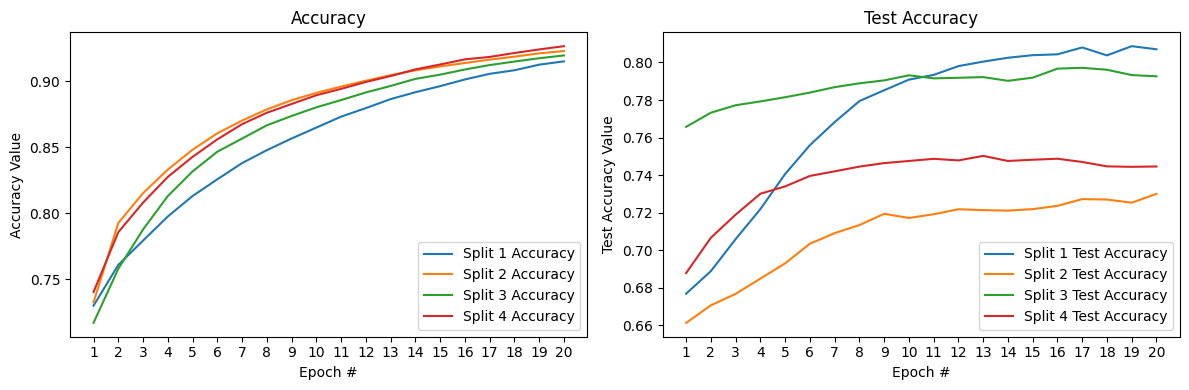

In [10]:
plot_metrics(all_histories, ["accuracy" , "val_accuracy"] )

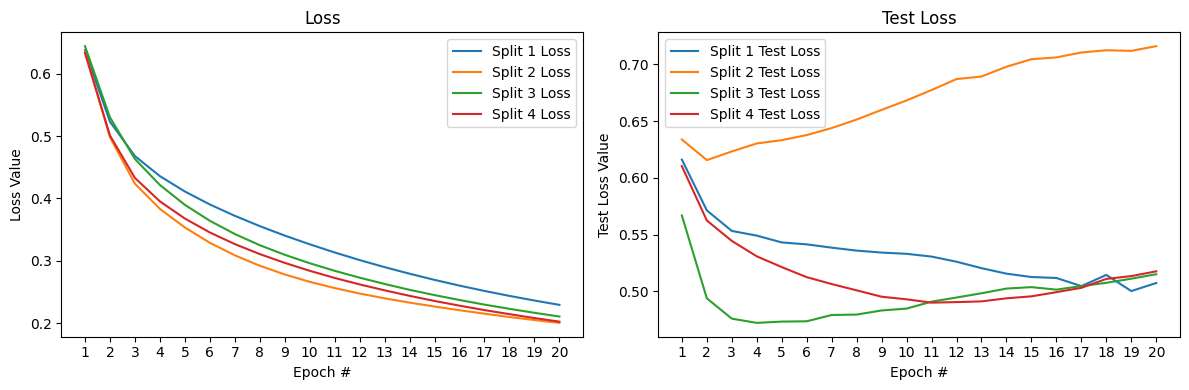

In [11]:
plot_metrics(all_histories, ["loss" , "val_loss"] )

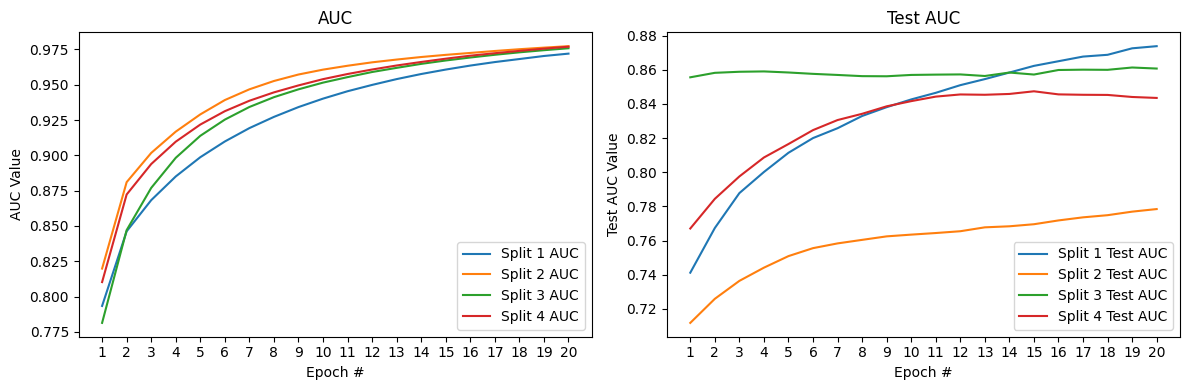

In [12]:
plot_metrics(all_histories, ["auc" , "val_auc"] )

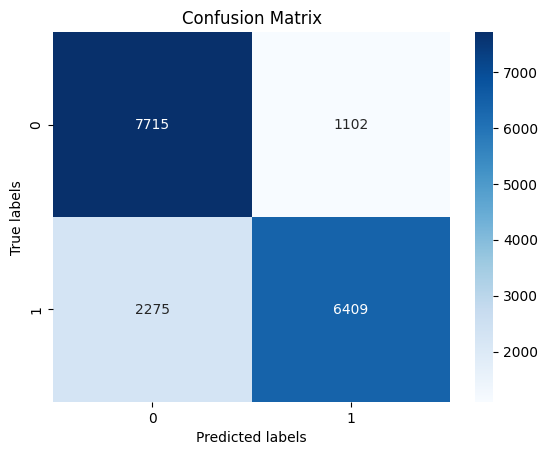

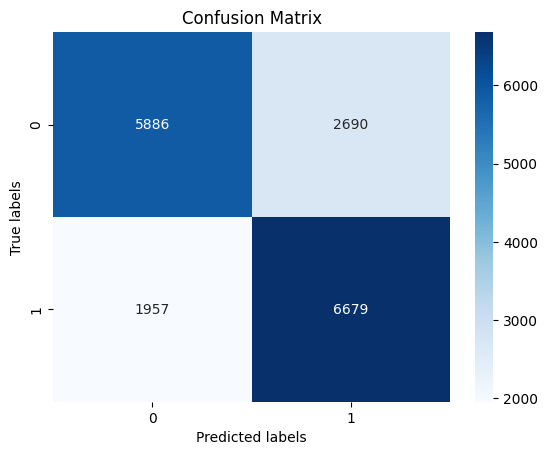

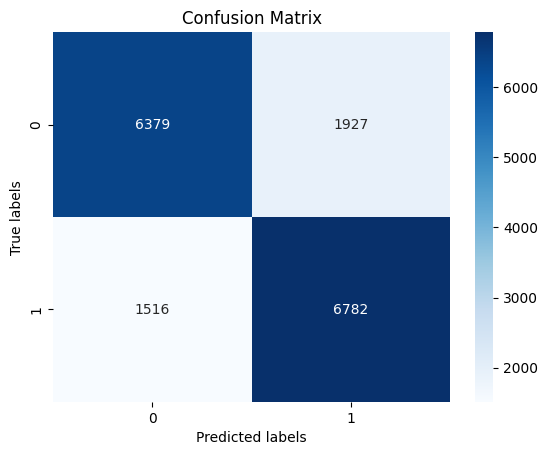

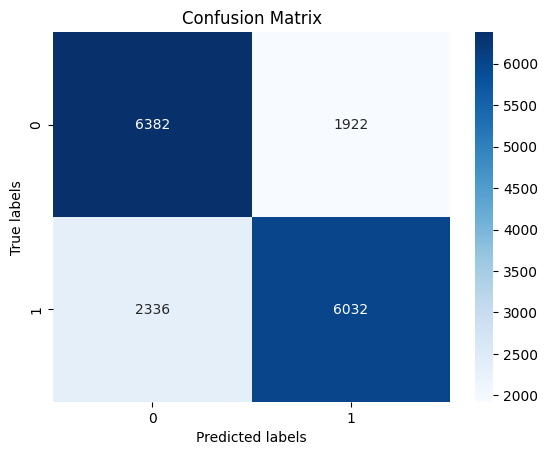

In [27]:
for i in range(4):
    plot_confusion_matrix(all_y_true[i], all_y_pred_binary[i] , [0 , 1])

In [31]:
for i in range(4):
    print(classification_report(all_y_true[i], all_y_pred_binary[i]))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82      8817
           1       0.85      0.74      0.79      8684

    accuracy                           0.81     17501
   macro avg       0.81      0.81      0.81     17501
weighted avg       0.81      0.81      0.81     17501

              precision    recall  f1-score   support

           0       0.75      0.69      0.72      8576
           1       0.71      0.77      0.74      8636

    accuracy                           0.73     17212
   macro avg       0.73      0.73      0.73     17212
weighted avg       0.73      0.73      0.73     17212

              precision    recall  f1-score   support

           0       0.81      0.77      0.79      8306
           1       0.78      0.82      0.80      8298

    accuracy                           0.79     16604
   macro avg       0.79      0.79      0.79     16604
weighted avg       0.79      0.79      0.79     16604

              preci

# high quality - resnet50 - freeze

In [13]:
def create_model(size = (224 , 224 , 3)):
    #with strategy.scope():
    vgg16_base = ResNet50(weights='imagenet', include_top=True, input_shape= size)

    for layer in vgg16_base.layers:
        layer.trainable = False

    model = Sequential()
    model.add(vgg16_base)
        #model.add(Flatten())
    model.add(Dense(256, activation='relu'))
        #model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy' ,Precision() , Recall() , AUC()])

    return model

In [14]:
num_folds = 4
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

Epochs = 20
batch_size = 64
epoch_list = list(range(1, Epochs + 1))
all_histories = []
result_train = []
result_test = []
all_y_true = []
all_y_pred_binary = []

#these two variables are used for kfold on persons. 
persons = np.arange(64)
labels = np.concatenate((np.ones(32), np.zeros(32)))


for fold_index, (train_index_p, test_index_p) in enumerate(kf.split(persons , labels)):
    
    K.clear_session()
    gc.collect()
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint_path = f"resnet_freeze_HQ_fold_{fold_index}.keras"
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    model = create_model((224 , 224 , 3)) 
    
    train_generator = MyDataGenerator(shuffled_high_real, train_index_p , batch_size)
    val_generator = MyDataGenerator(shuffled_high_real, test_index_p, batch_size )

    history = model.fit(train_generator, epochs=Epochs,validation_data=val_generator , callbacks = [checkpoint])

    all_histories.append(history.history)
    
    
    train_results = model.evaluate(train_generator)
    print("Metrics on train:")
    print(train_results)
    result_train.append(train_results)
        
    test_results = model.evaluate(val_generator)
    print("Metrics on test:")
    print(test_results)
    result_test.append(test_results)
    
    
    y_true =  val_generator.get_true_labels()
    y_pred = model.predict(val_generator)
    y_pred_binary = (y_pred > 0.5).astype(int) 
    all_y_pred_binary.append(y_pred_binary)
    all_y_true.append(y_true)

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20


I0000 00:00:1716620114.636435      84 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716620114.685946      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


195/789 ━━━━━━━━━━━━━━━━━━━━ 5:47 585ms/step - accuracy: 0.5673 - auc: 0.5922 - loss: 0.6911 - precision: 0.5495 - recall: 0.7716

W0000 00:00:1716620228.236319      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.6224 - auc: 0.6601 - loss: 0.6821 - precision: 0.5949 - recall: 0.7885

W0000 00:00:1716620534.704844      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.52300, saving model to resnet_freeze_HQ_fold_0.keras


W0000 00:00:1716620679.632157      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


789/789 ━━━━━━━━━━━━━━━━━━━━ 593s 718ms/step - accuracy: 0.6224 - auc: 0.6602 - loss: 0.6820 - precision: 0.5950 - recall: 0.7884 - val_accuracy: 0.5230 - val_auc: 0.5282 - val_loss: 0.6968 - val_precision: 0.5180 - val_recall: 0.5580
Epoch 2/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.6863 - auc: 0.7472 - loss: 0.6239 - precision: 0.6778 - recall: 0.7149
Epoch 2: val_accuracy improved from 0.52300 to 0.55928, saving model to resnet_freeze_HQ_fold_0.keras
789/789 ━━━━━━━━━━━━━━━━━━━━ 291s 366ms/step - accuracy: 0.6863 - auc: 0.7472 - loss: 0.6239 - precision: 0.6778 - recall: 0.7149 - val_accuracy: 0.5593 - val_auc: 0.5456 - val_loss: 0.7140 - val_precision: 0.5421 - val_recall: 0.7205
Epoch 3/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.7216 - auc: 0.7970 - loss: 0.5718 - precision: 0.7108 - recall: 0.7512
Epoch 3: val_accuracy improved from 0.55928 to 0.56460, saving model to resnet_freeze_HQ_fold_0.keras
789/789 ━━━━━━━━━━━━━━━━━━━━ 291s 366ms/step - a

W0000 00:00:1716626637.117216      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Metrics on train:
[0.31749531626701355, 0.8723657131195068, 0.8762269616127014, 0.8679155707359314, 0.9456189870834351]
274/274 ━━━━━━━━━━━━━━━━━━━━ 74s 270ms/step - accuracy: 0.5571 - auc: 0.5795 - loss: 1.0798 - precision: 0.5437 - recall: 0.6476
Metrics on test:
[1.0771055221557617, 0.5575109720230103, 0.5454721450805664, 0.6492399573326111, 0.5830988883972168]
  2/274 ━━━━━━━━━━━━━━━━━━━━ 47s 176ms/step

W0000 00:00:1716626716.842840      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


274/274 ━━━━━━━━━━━━━━━━━━━━ 80s 277ms/step


W0000 00:00:1716626792.561958      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/20
  1/794 ━━━━━━━━━━━━━━━━━━━━ 2:51:53 13s/step - accuracy: 0.5156 - auc: 0.5093 - loss: 0.6929 - precision: 0.0000e+00 - recall: 0.0000e+00

W0000 00:00:1716626808.244788      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


714/794 ━━━━━━━━━━━━━━━━━━━━ 23s 290ms/step - accuracy: 0.6046 - auc: 0.6736 - loss: 0.6862 - precision: 0.6744 - recall: 0.3672

W0000 00:00:1716627015.181449      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.6094 - auc: 0.6772 - loss: 0.6853 - precision: 0.6742 - recall: 0.3897

W0000 00:00:1716627040.703089      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.63078, saving model to resnet_freeze_HQ_fold_1.keras


W0000 00:00:1716627126.554104      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


794/794 ━━━━━━━━━━━━━━━━━━━━ 332s 402ms/step - accuracy: 0.6095 - auc: 0.6773 - loss: 0.6853 - precision: 0.6742 - recall: 0.3900 - val_accuracy: 0.6308 - val_auc: 0.6975 - val_loss: 0.6689 - val_precision: 0.6080 - val_recall: 0.7433
Epoch 2/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.6930 - auc: 0.7627 - loss: 0.6414 - precision: 0.6681 - recall: 0.7684
Epoch 2: val_accuracy improved from 0.63078 to 0.67087, saving model to resnet_freeze_HQ_fold_1.keras
794/794 ━━━━━━━━━━━━━━━━━━━━ 290s 363ms/step - accuracy: 0.6930 - auc: 0.7627 - loss: 0.6414 - precision: 0.6681 - recall: 0.7684 - val_accuracy: 0.6709 - val_auc: 0.7323 - val_loss: 0.6406 - val_precision: 0.6512 - val_recall: 0.7409
Epoch 3/20
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.7246 - auc: 0.8056 - loss: 0.5884 - precision: 0.6983 - recall: 0.7832
Epoch 3: val_accuracy improved from 0.67087 to 0.69080, saving model to resnet_freeze_HQ_fold_1.keras
794/794 ━━━━━━━━━━━━━━━━━━━━ 292s 365ms/step - a

W0000 00:00:1716633133.943818      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Metrics on train:
[0.3008365035057068, 0.8870748281478882, 0.874579906463623, 0.9033530354499817, 0.9534806609153748]
269/269 ━━━━━━━━━━━━━━━━━━━━ 73s 270ms/step - accuracy: 0.6973 - auc: 0.7364 - loss: 0.7030 - precision: 0.6813 - recall: 0.7388
Metrics on test:
[0.7034182548522949, 0.6955612301826477, 0.6826984882354736, 0.7347151637077332, 0.7348014712333679]
  2/269 ━━━━━━━━━━━━━━━━━━━━ 48s 181ms/step

W0000 00:00:1716633212.283212      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


269/269 ━━━━━━━━━━━━━━━━━━━━ 79s 281ms/step


W0000 00:00:1716633287.594226      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/20
  1/803 ━━━━━━━━━━━━━━━━━━━━ 2:50:04 13s/step - accuracy: 0.4062 - auc: 0.5303 - loss: 0.6936 - precision: 0.4222 - recall: 0.6129

W0000 00:00:1716633303.089134      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


735/803 ━━━━━━━━━━━━━━━━━━━━ 20s 300ms/step - accuracy: 0.6371 - auc: 0.6742 - loss: 0.6840 - precision: 0.6587 - recall: 0.5582

W0000 00:00:1716633523.423728      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


803/803 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.6393 - auc: 0.6767 - loss: 0.6830 - precision: 0.6600 - recall: 0.5645

W0000 00:00:1716633548.085380      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.55655, saving model to resnet_freeze_HQ_fold_2.keras


W0000 00:00:1716633627.404695      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


803/803 ━━━━━━━━━━━━━━━━━━━━ 338s 405ms/step - accuracy: 0.6393 - auc: 0.6768 - loss: 0.6830 - precision: 0.6601 - recall: 0.5646 - val_accuracy: 0.5566 - val_auc: 0.5899 - val_loss: 0.6791 - val_precision: 0.5620 - val_recall: 0.5106
Epoch 2/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.6980 - auc: 0.7626 - loss: 0.6258 - precision: 0.6975 - recall: 0.6976
Epoch 2: val_accuracy improved from 0.55655 to 0.57926, saving model to resnet_freeze_HQ_fold_2.keras
803/803 ━━━━━━━━━━━━━━━━━━━━ 302s 373ms/step - accuracy: 0.6981 - auc: 0.7626 - loss: 0.6258 - precision: 0.6975 - recall: 0.6976 - val_accuracy: 0.5793 - val_auc: 0.6183 - val_loss: 0.6638 - val_precision: 0.5805 - val_recall: 0.5700
Epoch 3/20
803/803 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.7331 - auc: 0.8091 - loss: 0.5689 - precision: 0.7242 - recall: 0.7516
Epoch 3: val_accuracy improved from 0.57926 to 0.58106, saving model to resnet_freeze_HQ_fold_2.keras
803/803 ━━━━━━━━━━━━━━━━━━━━ 315s 389ms/step - a

W0000 00:00:1716639573.624054      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Metrics on train:
[0.2999703586101532, 0.8820083737373352, 0.8823300004005432, 0.8815400004386902, 0.9523290991783142]
260/260 ━━━━━━━━━━━━━━━━━━━━ 71s 272ms/step - accuracy: 0.6759 - auc: 0.7496 - loss: 0.6782 - precision: 0.6967 - recall: 0.6200
Metrics on test:
[0.6728139519691467, 0.6807395815849304, 0.7033518552780151, 0.6246083378791809, 0.7545870542526245]
  2/260 ━━━━━━━━━━━━━━━━━━━━ 47s 183ms/step

W0000 00:00:1716639649.439656      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


260/260 ━━━━━━━━━━━━━━━━━━━━ 76s 278ms/step


W0000 00:00:1716639721.450183      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/20
  1/802 ━━━━━━━━━━━━━━━━━━━━ 2:46:48 12s/step - accuracy: 0.4062 - auc: 0.5113 - loss: 0.6930 - precision: 0.3846 - recall: 0.1429

W0000 00:00:1716639736.928238      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


716/802 ━━━━━━━━━━━━━━━━━━━━ 25s 291ms/step - accuracy: 0.6227 - auc: 0.6720 - loss: 0.6861 - precision: 0.6514 - recall: 0.5113

W0000 00:00:1716639944.902688      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.6268 - auc: 0.6764 - loss: 0.6851 - precision: 0.6535 - recall: 0.5241

W0000 00:00:1716639972.987958      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.57618, saving model to resnet_freeze_HQ_fold_3.keras


W0000 00:00:1716640051.392626      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


802/802 ━━━━━━━━━━━━━━━━━━━━ 328s 393ms/step - accuracy: 0.6268 - auc: 0.6764 - loss: 0.6851 - precision: 0.6535 - recall: 0.5243 - val_accuracy: 0.5762 - val_auc: 0.6326 - val_loss: 0.6748 - val_precision: 0.6249 - val_recall: 0.3893
Epoch 2/20
802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.6981 - auc: 0.7665 - loss: 0.6353 - precision: 0.6923 - recall: 0.7105
Epoch 2: val_accuracy improved from 0.57618 to 0.59417, saving model to resnet_freeze_HQ_fold_3.keras
802/802 ━━━━━━━━━━━━━━━━━━━━ 360s 446ms/step - accuracy: 0.6982 - auc: 0.7665 - loss: 0.6353 - precision: 0.6923 - recall: 0.7105 - val_accuracy: 0.5942 - val_auc: 0.6504 - val_loss: 0.6585 - val_precision: 0.6340 - val_recall: 0.4528
Epoch 3/20
802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.7245 - auc: 0.8015 - loss: 0.5822 - precision: 0.7152 - recall: 0.7449
Epoch 3: val_accuracy improved from 0.59417 to 0.61486, saving model to resnet_freeze_HQ_fold_3.keras
802/802 ━━━━━━━━━━━━━━━━━━━━ 305s 377ms/step - a

W0000 00:00:1716646097.000714      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Metrics on train:
[0.3019276559352875, 0.8864119052886963, 0.8912570476531982, 0.8798110485076904, 0.9538655877113342]
261/261 ━━━━━━━━━━━━━━━━━━━━ 71s 272ms/step - accuracy: 0.6447 - auc: 0.7167 - loss: 0.7561 - precision: 0.6798 - recall: 0.5533
Metrics on test:
[0.7455995082855225, 0.6503719091415405, 0.6850313544273376, 0.5616635084152222, 0.720994234085083]
  2/261 ━━━━━━━━━━━━━━━━━━━━ 47s 182ms/step

W0000 00:00:1716646173.857455      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


261/261 ━━━━━━━━━━━━━━━━━━━━ 77s 280ms/step


W0000 00:00:1716646246.698851      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


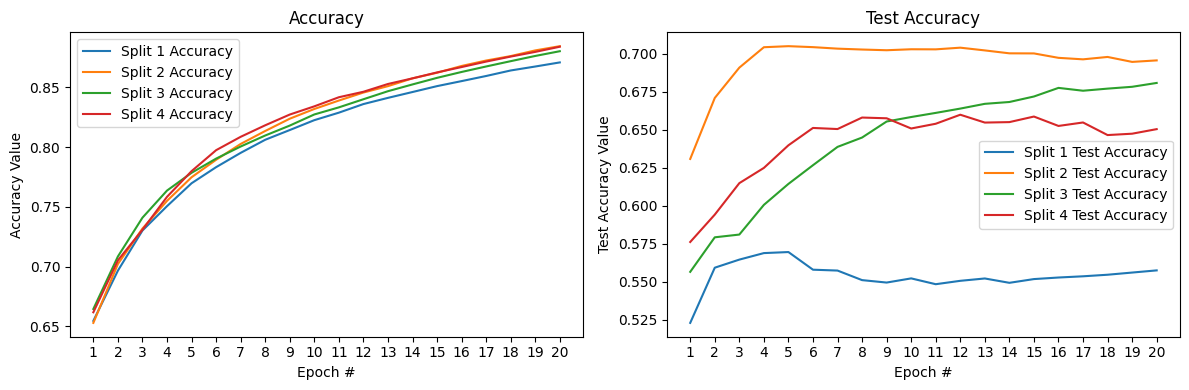

In [14]:
plot_metrics(all_histories, ["accuracy" , "val_accuracy"] )

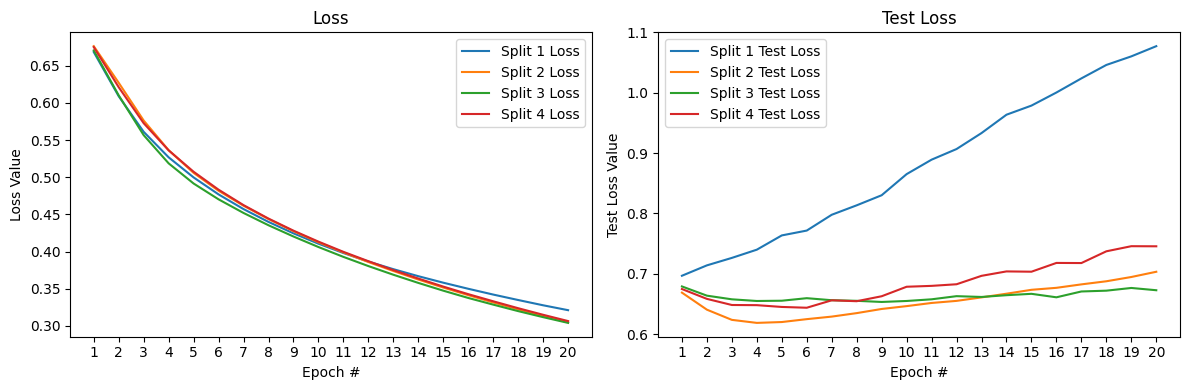

In [15]:
plot_metrics(all_histories, ["loss" , "val_loss"] )

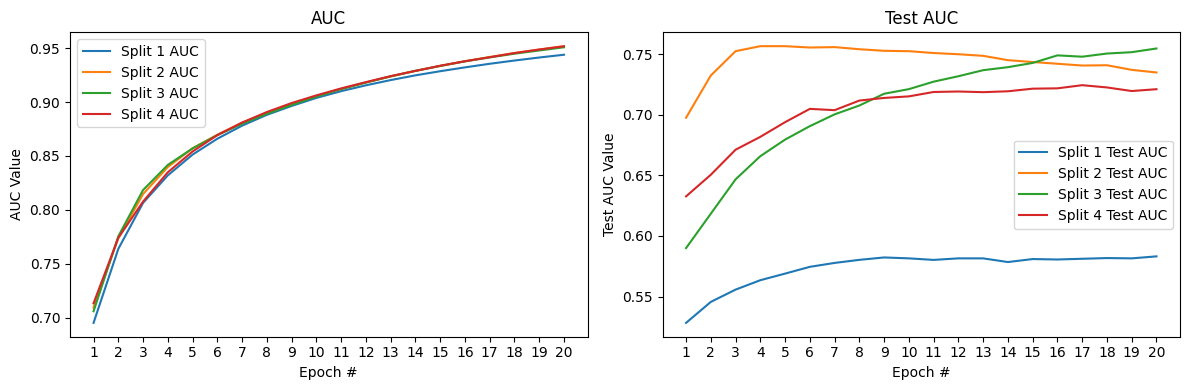

In [16]:
plot_metrics(all_histories, ["auc" , "val_auc"] )

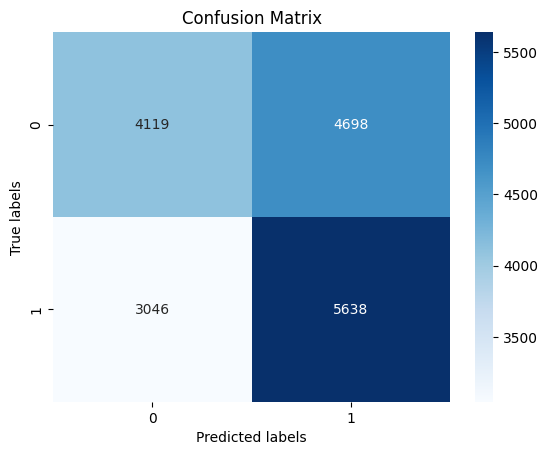

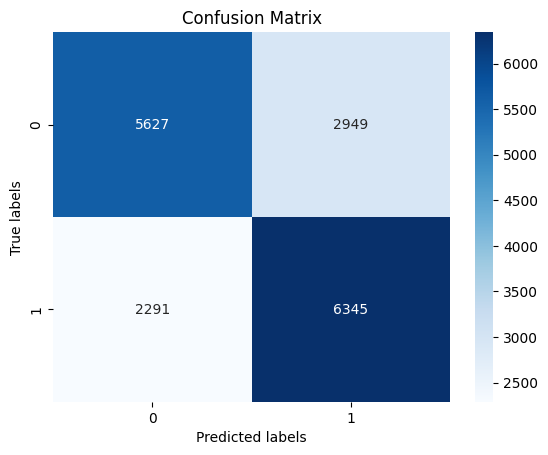

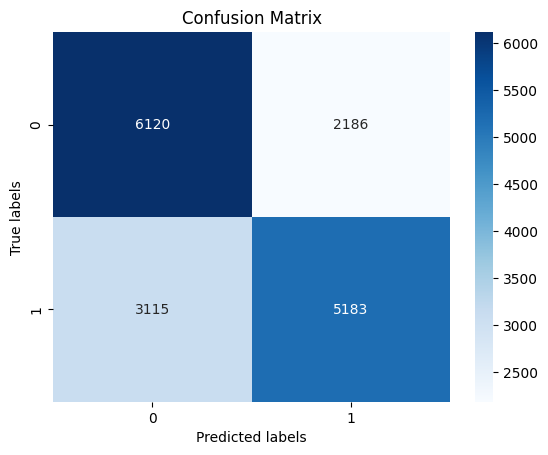

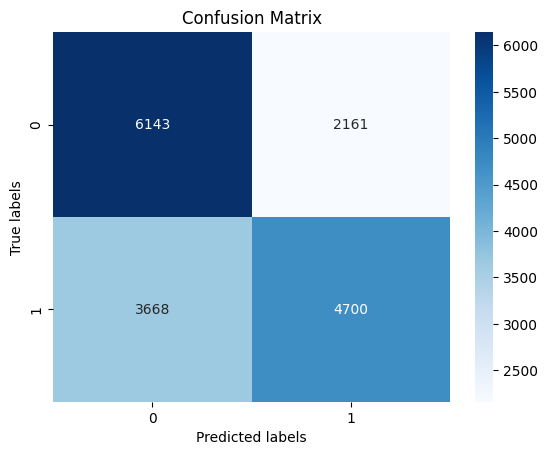

In [32]:
for i in range(4):
    plot_confusion_matrix(all_y_true[i], all_y_pred_binary[i] , [0 , 1])

In [33]:
for i in range(4):
    print(classification_report(all_y_true[i], all_y_pred_binary[i]))

              precision    recall  f1-score   support

           0       0.57      0.47      0.52      8817
           1       0.55      0.65      0.59      8684

    accuracy                           0.56     17501
   macro avg       0.56      0.56      0.55     17501
weighted avg       0.56      0.56      0.55     17501

              precision    recall  f1-score   support

           0       0.71      0.66      0.68      8576
           1       0.68      0.73      0.71      8636

    accuracy                           0.70     17212
   macro avg       0.70      0.70      0.70     17212
weighted avg       0.70      0.70      0.70     17212

              precision    recall  f1-score   support

           0       0.66      0.74      0.70      8306
           1       0.70      0.62      0.66      8298

    accuracy                           0.68     16604
   macro avg       0.68      0.68      0.68     16604
weighted avg       0.68      0.68      0.68     16604

              preci

# high quality - vgg16 - unfreeze 1000

In [11]:
def create_model(size = (224 , 224 , 3)):
    #with strategy.scope():
    vgg16_base = VGG16(weights='imagenet', include_top=True, input_shape= size)

    for layer in vgg16_base.layers[:-1]:
        layer.trainable = False

    model = Sequential()
    model.add(vgg16_base)
        #model.add(Flatten())
    model.add(Dense(256, activation='relu'))
        #model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy' ,Precision() , Recall() , AUC()])

    return model

In [12]:
num_folds = 4
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

Epochs = 5 
batch_size = 64
epoch_list = list(range(1, Epochs + 1))
all_histories = []
result_train = []
result_test = []
all_y_true = []
all_y_pred_binary = []

#these two variables are used for kfold on persons. 
persons = np.arange(64)
labels = np.concatenate((np.ones(32), np.zeros(32)))


for fold_index, (train_index_p, test_index_p) in enumerate(kf.split(persons , labels)):
    
    K.clear_session()
    gc.collect()
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint_path = f"vgg_freeze__LQ_fold_{fold_index}.keras"
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    model = create_model((224 , 224 , 3)) 
    
    train_generator = MyDataGenerator(shuffled_high_real, train_index_p , batch_size)
    val_generator = MyDataGenerator(shuffled_high_real, test_index_p, batch_size )

    history = model.fit(train_generator, epochs=Epochs,validation_data=val_generator , callbacks = [checkpoint])

    all_histories.append(history.history)
    
    
    train_results = model.evaluate(train_generator)
    print("Metrics on train:")
    print(train_results)
    result_train.append(train_results)
        
    test_results = model.evaluate(val_generator)
    print("Metrics on test:")
    print(test_results)
    result_test.append(test_results)
    
    
    y_true =  val_generator.get_true_labels()
    y_pred = model.predict(val_generator)
    y_pred_binary = (y_pred > 0.5).astype(int) 
    all_y_pred_binary.append(y_pred_binary)
    all_y_true.append(y_true)

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1716179302.580829     125 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716179302.602556     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 47/789 ━━━━━━━━━━━━━━━━━━━━ 10:30 849ms/step - accuracy: 0.6819 - auc: 0.7461 - loss: 0.6885 - precision: 0.6306 - recall: 0.9040

W0000 00:00:1716179397.573867     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9966 - auc: 0.9999 - loss: 0.0506 - precision: 0.9961 - recall: 0.9970
Epoch 2: val_accuracy improved from 0.79938 to 0.80327, saving model to vgg_freeze__LQ_fold_0.keras
789/789 ━━━━━━━━━━━━━━━━━━━━ 333s 419ms/step - accuracy: 0.9966 - auc: 0.9999 - loss: 0.0506 - precision: 0.9961 - recall: 0.9970 - val_accuracy: 0.8033 - val_auc: 0.8861 - val_loss: 0.5496 - val_precision: 0.8213 - val_recall: 0.7714
Epoch 3/5
233/789 ━━━━━━━━━━━━━━━━━━━━ 2:38 285ms/step - accuracy: 0.9981 - auc: 1.0000 - loss: 0.0171 - precision: 0.9976 - recall: 0.9987
Epoch 4: val_accuracy did not improve from 0.80818
789/789 ━━━━━━━━━━━━━━━━━━━━ 322s 382ms/step - accuracy: 0.9988 - auc: 1.0000 - loss: 0.0077 - precision: 0.9987 - recall: 0.9989 - val_accuracy: 0.7967 - val_auc: 0.8708 - val_loss: 0.7291 - val_precision: 0.8247 - val_recall: 0.7497
Epoch 5/5
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.8953 - auc: 0.9511 - loss: 0.5124 - precisio

W0000 00:00:1716182134.211556     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716182270.677137     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.80270, saving model to vgg_freeze__LQ_fold_1.keras
794/794 ━━━━━━━━━━━━━━━━━━━━ 405s 503ms/step - accuracy: 0.8954 - auc: 0.9512 - loss: 0.5122 - precision: 0.9094 - recall: 0.8718 - val_accuracy: 0.8027 - val_auc: 0.8811 - val_loss: 0.4605 - val_precision: 0.7637 - val_recall: 0.8786
Epoch 2/5
126/794 ━━━━━━━━━━━━━━━━━━━━ 3:18 297ms/step - accuracy: 0.9909 - auc: 0.9995 - loss: 0.1051 - precision: 0.9900 - recall: 0.9919
Epoch 3: val_accuracy did not improve from 0.80270
794/794 ━━━━━━━━━━━━━━━━━━━━ 306s 383ms/step - accuracy: 0.9973 - auc: 0.9999 - loss: 0.0231 - precision: 0.9971 - recall: 0.9974 - val_accuracy: 0.7785 - val_auc: 0.8656 - val_loss: 0.7069 - val_precision: 0.7467 - val_recall: 0.8453
Epoch 4/5
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9981 - auc: 1.0000 - loss: 0.0112 - precision: 0.9981 - recall: 0.9981
Epoch 4: val_accuracy did not improve from 0.80270
794/794 ━━━━━━━━━━━━━━━━━━━━ 307s 384ms/step - accur

W0000 00:00:1716183736.705632     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Metrics on train:
[0.0037911441177129745, 0.9995470643043518, 0.9997631907463074, 0.9993293881416321, 0.9999983906745911]
269/269 ━━━━━━━━━━━━━━━━━━━━ 77s 287ms/step - accuracy: 0.7734 - auc: 0.8420 - loss: 0.9069 - precision: 0.7439 - recall: 0.8400
Metrics on test:
[0.9091607928276062, 0.7720776200294495, 0.739165723323822, 0.8433302640914917, 0.8412350416183472]
  1/269 ━━━━━━━━━━━━━━━━━━━━ 4:19 970ms/step

W0000 00:00:1716183816.360790     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


269/269 ━━━━━━━━━━━━━━━━━━━━ 74s 273ms/step


W0000 00:00:1716183889.457852     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/5


W0000 00:00:1716183898.419760     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


133/803 ━━━━━━━━━━━━━━━━━━━━ 3:10 284ms/step - accuracy: 0.7237 - auc: 0.8271 - loss: 0.6736 - precision: 0.6681 - recall: 0.9379

W0000 00:00:1716183988.901483     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


803/803 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8837 - auc: 0.9467 - loss: 0.5015 - precision: 0.8440 - recall: 0.9621

W0000 00:00:1716184217.283523     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.83805, saving model to vgg_freeze__LQ_fold_2.keras


W0000 00:00:1716184335.281115     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


803/803 ━━━━━━━━━━━━━━━━━━━━ 444s 547ms/step - accuracy: 0.8838 - auc: 0.9468 - loss: 0.5013 - precision: 0.8441 - recall: 0.9622 - val_accuracy: 0.8381 - val_auc: 0.9218 - val_loss: 0.3764 - val_precision: 0.8756 - val_recall: 0.7879
Epoch 2/5
803/803 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.9954 - auc: 0.9998 - loss: 0.0579 - precision: 0.9953 - recall: 0.9956
Epoch 2: val_accuracy improved from 0.83805 to 0.83914, saving model to vgg_freeze__LQ_fold_2.keras
803/803 ━━━━━━━━━━━━━━━━━━━━ 337s 417ms/step - accuracy: 0.9954 - auc: 0.9998 - loss: 0.0579 - precision: 0.9953 - recall: 0.9956 - val_accuracy: 0.8391 - val_auc: 0.9213 - val_loss: 0.4279 - val_precision: 0.8191 - val_recall: 0.8703
Epoch 3/5
803/803 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.9980 - auc: 0.9999 - loss: 0.0167 - precision: 0.9981 - recall: 0.9979
Epoch 3: val_accuracy did not improve from 0.83914
803/803 ━━━━━━━━━━━━━━━━━━━━ 359s 444ms/step - accuracy: 0.9980 - auc: 0.9999 - loss: 0.0167 - precisio

W0000 00:00:1716186004.873435     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


803/803 ━━━━━━━━━━━━━━━━━━━━ 256s 319ms/step - accuracy: 0.9994 - auc: 1.0000 - loss: 0.0034 - precision: 0.9989 - recall: 0.9999
Metrics on train:
[0.0033989264629781246, 0.9994550943374634, 0.9989500045776367, 0.9999610781669617, 0.9999601244926453]
260/260 ━━━━━━━━━━━━━━━━━━━━ 89s 340ms/step - accuracy: 0.8516 - auc: 0.9216 - loss: 0.5231 - precision: 0.8399 - recall: 0.8706
Metrics on test:
[0.5434173941612244, 0.8461214303970337, 0.8339341878890991, 0.8641841411590576, 0.9179583787918091]
  1/260 ━━━━━━━━━━━━━━━━━━━━ 4:03 939ms/step

W0000 00:00:1716186095.887388     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


260/260 ━━━━━━━━━━━━━━━━━━━━ 72s 276ms/step


W0000 00:00:1716186167.312042     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/5


W0000 00:00:1716186176.646029     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


294/802 ━━━━━━━━━━━━━━━━━━━━ 2:48 332ms/step - accuracy: 0.8067 - auc: 0.8971 - loss: 0.6436 - precision: 0.7454 - recall: 0.9578

W0000 00:00:1716186324.229134     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.8818 - auc: 0.9459 - loss: 0.5199 - precision: 0.8373 - recall: 0.9652

W0000 00:00:1716186497.032235     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.81394, saving model to vgg_freeze__LQ_fold_3.keras


W0000 00:00:1716186618.027950     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


802/802 ━━━━━━━━━━━━━━━━━━━━ 449s 553ms/step - accuracy: 0.8819 - auc: 0.9460 - loss: 0.5196 - precision: 0.8374 - recall: 0.9652 - val_accuracy: 0.8139 - val_auc: 0.9008 - val_loss: 0.4216 - val_precision: 0.8721 - val_recall: 0.7375
Epoch 2/5
802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.9940 - auc: 0.9998 - loss: 0.0552 - precision: 0.9924 - recall: 0.9956
Epoch 2: val_accuracy improved from 0.81394 to 0.82012, saving model to vgg_freeze__LQ_fold_3.keras
802/802 ━━━━━━━━━━━━━━━━━━━━ 334s 413ms/step - accuracy: 0.9940 - auc: 0.9998 - loss: 0.0552 - precision: 0.9924 - recall: 0.9956 - val_accuracy: 0.8201 - val_auc: 0.9064 - val_loss: 0.4741 - val_precision: 0.8686 - val_recall: 0.7560
Epoch 3/5
802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.9978 - auc: 1.0000 - loss: 0.0168 - precision: 0.9976 - recall: 0.9979
Epoch 3: val_accuracy did not improve from 0.82012
802/802 ━━━━━━━━━━━━━━━━━━━━ 333s 413ms/step - accuracy: 0.9978 - auc: 1.0000 - loss: 0.0168 - precisio

W0000 00:00:1716188299.471481     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


802/802 ━━━━━━━━━━━━━━━━━━━━ 289s 360ms/step - accuracy: 0.9996 - auc: 1.0000 - loss: 0.0029 - precision: 0.9994 - recall: 0.9999
Metrics on train:
[0.002967891516163945, 0.9994933605194092, 0.9991418123245239, 0.9998438358306885, 0.9999790787696838]
261/261 ━━━━━━━━━━━━━━━━━━━━ 88s 338ms/step - accuracy: 0.8021 - auc: 0.8727 - loss: 0.7307 - precision: 0.8177 - recall: 0.7843
Metrics on test:
[0.7528077960014343, 0.7983445525169373, 0.8125624656677246, 0.7776051759719849, 0.8673231601715088]
  1/261 ━━━━━━━━━━━━━━━━━━━━ 4:09 960ms/step

W0000 00:00:1716188390.375323     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


261/261 ━━━━━━━━━━━━━━━━━━━━ 73s 279ms/step


W0000 00:00:1716188462.806406     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


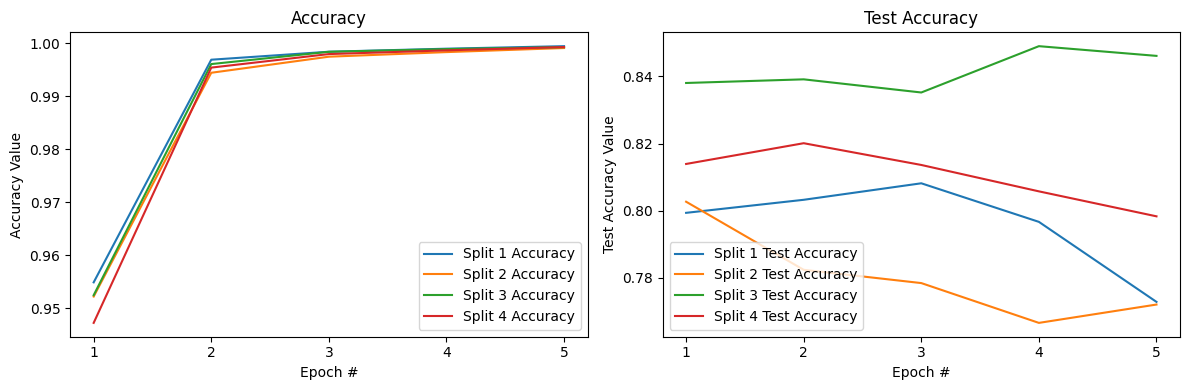

In [23]:
plot_metrics(all_histories, ["accuracy" , "val_accuracy"] )

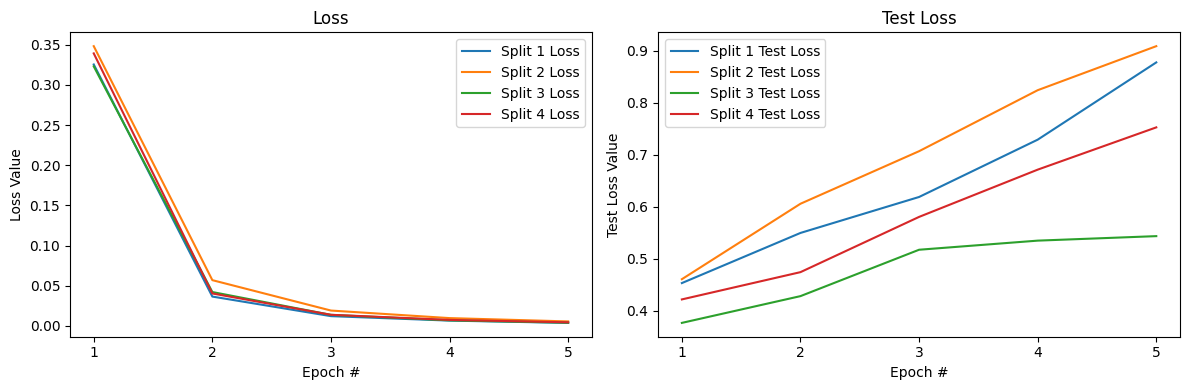

In [24]:
plot_metrics(all_histories, ["loss" , "val_loss"] )

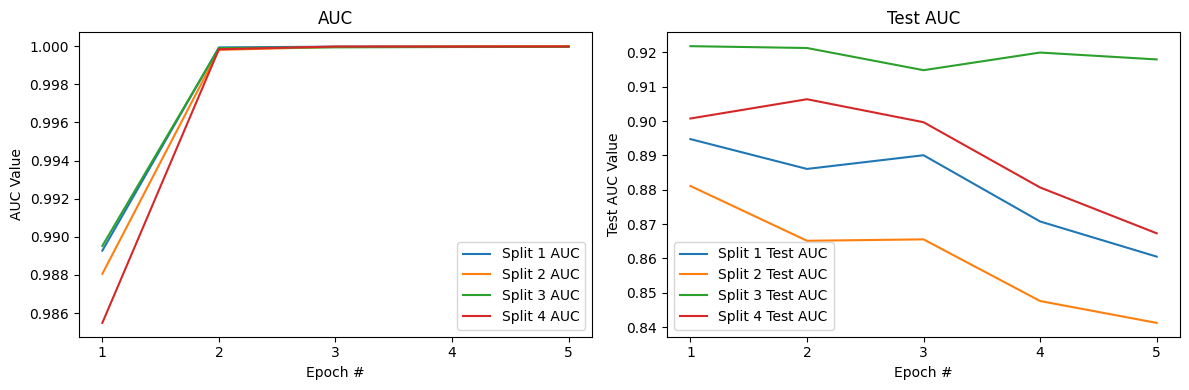

In [25]:
plot_metrics(all_histories, ["auc" , "val_auc"] )

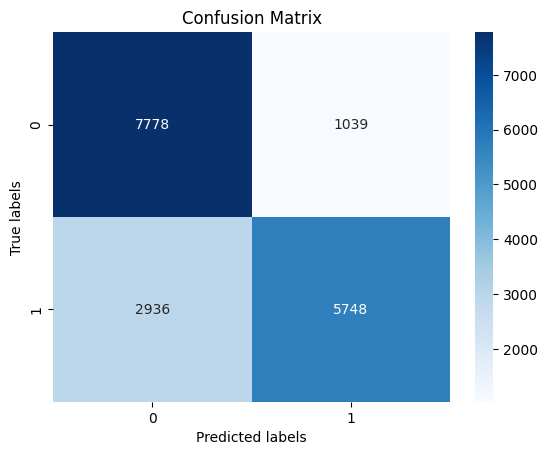

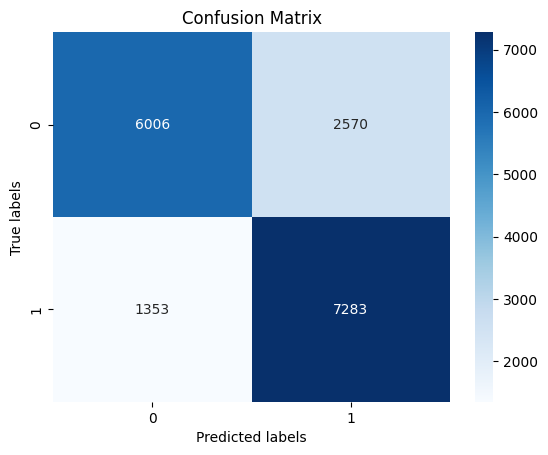

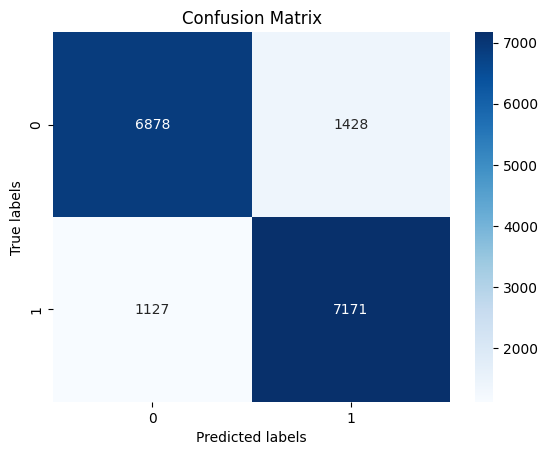

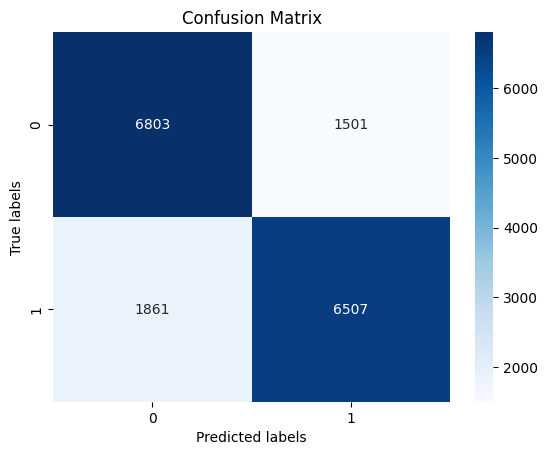

In [24]:
for i in range(4):
    plot_confusion_matrix(all_y_true[i], all_y_pred_binary[i] , [0 , 1])

In [25]:
for i in range(4):
    print(classification_report(all_y_true[i], all_y_pred_binary[i]))

              precision    recall  f1-score   support

           0       0.73      0.88      0.80      8817
           1       0.85      0.66      0.74      8684

    accuracy                           0.77     17501
   macro avg       0.79      0.77      0.77     17501
weighted avg       0.79      0.77      0.77     17501

              precision    recall  f1-score   support

           0       0.82      0.70      0.75      8576
           1       0.74      0.84      0.79      8636

    accuracy                           0.77     17212
   macro avg       0.78      0.77      0.77     17212
weighted avg       0.78      0.77      0.77     17212

              precision    recall  f1-score   support

           0       0.86      0.83      0.84      8306
           1       0.83      0.86      0.85      8298

    accuracy                           0.85     16604
   macro avg       0.85      0.85      0.85     16604
weighted avg       0.85      0.85      0.85     16604

              preci

# high quality - resnet50 - unfreeze 1000 

In [18]:
def create_model(size = (224 , 224 , 3)):
    #with strategy.scope():
    vgg16_base = VGG16(weights='imagenet', include_top=True, input_shape= size)

    for layer in vgg16_base.layers[:-1]:
        layer.trainable = False

    model = Sequential()
    model.add(vgg16_base)
        #model.add(Flatten())
    model.add(Dense(256, activation='relu'))
        #model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy' ,Precision() , Recall() , AUC()])

    return model

In [14]:
num_folds = 4
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

Epochs = 5 
batch_size = 64
epoch_list = list(range(1, Epochs + 1))
all_histories = []
result_train = []
result_test = []
all_y_true = []
all_y_pred_binary = []

#these two variables are used for kfold on persons. 
persons = np.arange(64)
labels = np.concatenate((np.ones(32), np.zeros(32)))


for fold_index, (train_index_p, test_index_p) in enumerate(kf.split(persons , labels)):
    
    K.clear_session()
    gc.collect()
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint_path = f"resnet_unfreeze__HQ_fold_{fold_index}.keras"
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    model = create_model((224 , 224 , 3)) 
    
    train_generator = MyDataGenerator(shuffled_high_real, train_index_p , batch_size)
    val_generator = MyDataGenerator(shuffled_high_real, test_index_p, batch_size )

    history = model.fit(train_generator, epochs=Epochs,validation_data=val_generator , callbacks = [checkpoint])

    all_histories.append(history.history)
    
    
    train_results = model.evaluate(train_generator)
    print("Metrics on train:")
    print(train_results)
    result_train.append(train_results)
        
    test_results = model.evaluate(val_generator)
    print("Metrics on test:")
    print(test_results)
    result_test.append(test_results)
    
    
    y_true =  val_generator.get_true_labels()
    y_pred = model.predict(val_generator)
    y_pred_binary = (y_pred > 0.5).astype(int) 
    all_y_pred_binary.append(y_pred_binary)
    all_y_true.append(y_true)

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5


I0000 00:00:1716180239.540620     149 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716180239.591691     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


433/789 ━━━━━━━━━━━━━━━━━━━━ 3:08 530ms/step - accuracy: 0.7573 - auc: 0.8250 - loss: 0.6392 - precision: 0.7757 - recall: 0.7026

W0000 00:00:1716180468.748378     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.8202 - auc: 0.8878 - loss: 0.5533 - precision: 0.8331 - recall: 0.7867

W0000 00:00:1716180649.793547     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.63779, saving model to resnet_unfreeze__HQ_fold_0.keras


W0000 00:00:1716180794.016505     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


789/789 ━━━━━━━━━━━━━━━━━━━━ 582s 704ms/step - accuracy: 0.8203 - auc: 0.8879 - loss: 0.5531 - precision: 0.8332 - recall: 0.7868 - val_accuracy: 0.6378 - val_auc: 0.6586 - val_loss: 0.8025 - val_precision: 0.6383 - val_recall: 0.6232
Epoch 2/5
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9950 - auc: 0.9998 - loss: 0.0582 - precision: 0.9951 - recall: 0.9950
Epoch 2: val_accuracy improved from 0.63779 to 0.69076, saving model to resnet_unfreeze__HQ_fold_0.keras
789/789 ━━━━━━━━━━━━━━━━━━━━ 294s 370ms/step - accuracy: 0.9950 - auc: 0.9998 - loss: 0.0582 - precision: 0.9951 - recall: 0.9950 - val_accuracy: 0.6908 - val_auc: 0.7198 - val_loss: 0.9357 - val_precision: 0.6923 - val_recall: 0.6783
Epoch 3/5
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.9991 - auc: 1.0000 - loss: 0.0132 - precision: 0.9990 - recall: 0.9992
Epoch 3: val_accuracy improved from 0.69076 to 0.71436, saving model to resnet_unfreeze__HQ_fold_0.keras
789/789 ━━━━━━━━━━━━━━━━━━━━ 297s 374ms/step

W0000 00:00:1716182207.582444     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Metrics on train:
[0.0016614643391221762, 0.9999207854270935, 0.9999999403953552, 0.9999209642410278, 0.9999209642410278]
274/274 ━━━━━━━━━━━━━━━━━━━━ 75s 274ms/step - accuracy: 0.7255 - auc: 0.7629 - loss: 1.2105 - precision: 0.7350 - recall: 0.6961
Metrics on test:
[1.1956062316894531, 0.7240729331970215, 0.7653228640556335, 0.7354342341423035, 0.6933440566062927]
  2/274 ━━━━━━━━━━━━━━━━━━━━ 46s 172ms/step

W0000 00:00:1716182287.948092     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


274/274 ━━━━━━━━━━━━━━━━━━━━ 80s 278ms/step


W0000 00:00:1716182363.769511     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/5
  1/794 ━━━━━━━━━━━━━━━━━━━━ 2:52:26 13s/step - accuracy: 0.4219 - auc: 0.4643 - loss: 0.6935 - precision: 0.3548 - recall: 0.3929

W0000 00:00:1716182378.927677     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


602/794 ━━━━━━━━━━━━━━━━━━━━ 55s 289ms/step - accuracy: 0.7607 - auc: 0.8545 - loss: 0.6049 - precision: 0.8669 - recall: 0.5774

W0000 00:00:1716182552.498749     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.7945 - auc: 0.8833 - loss: 0.5629 - precision: 0.8872 - recall: 0.6419

W0000 00:00:1716182610.323580     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.76121, saving model to resnet_unfreeze__HQ_fold_1.keras


W0000 00:00:1716182696.926509     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


794/794 ━━━━━━━━━━━━━━━━━━━━ 332s 402ms/step - accuracy: 0.7946 - auc: 0.8834 - loss: 0.5626 - precision: 0.8873 - recall: 0.6421 - val_accuracy: 0.7612 - val_auc: 0.8323 - val_loss: 0.5163 - val_precision: 0.7311 - val_recall: 0.8291
Epoch 2/5
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9946 - auc: 0.9998 - loss: 0.0765 - precision: 0.9937 - recall: 0.9956
Epoch 2: val_accuracy improved from 0.76121 to 0.79758, saving model to resnet_unfreeze__HQ_fold_1.keras
794/794 ━━━━━━━━━━━━━━━━━━━━ 293s 366ms/step - accuracy: 0.9946 - auc: 0.9998 - loss: 0.0764 - precision: 0.9937 - recall: 0.9956 - val_accuracy: 0.7976 - val_auc: 0.8711 - val_loss: 0.5012 - val_precision: 0.7763 - val_recall: 0.8380
Epoch 3/5
794/794 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9982 - auc: 1.0000 - loss: 0.0187 - precision: 0.9980 - recall: 0.9984
Epoch 3: val_accuracy improved from 0.79758 to 0.81920, saving model to resnet_unfreeze__HQ_fold_1.keras
794/794 ━━━━━━━━━━━━━━━━━━━━ 299s 374ms/step

W0000 00:00:1716184101.391215     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Metrics on train:
[0.00258295307867229, 0.9998030662536621, 0.9999999403953552, 0.9998421669006348, 0.9997633099555969]
269/269 ━━━━━━━━━━━━━━━━━━━━ 75s 279ms/step - accuracy: 0.8329 - auc: 0.9108 - loss: 0.5050 - precision: 0.8146 - recall: 0.8657
Metrics on test:
[0.504646897315979, 0.8327910900115967, 0.909496009349823, 0.815403163433075, 0.8618573546409607]
  2/269 ━━━━━━━━━━━━━━━━━━━━ 46s 173ms/step

W0000 00:00:1716184181.669248     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


269/269 ━━━━━━━━━━━━━━━━━━━━ 79s 279ms/step


W0000 00:00:1716184256.471772     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/5
  1/803 ━━━━━━━━━━━━━━━━━━━━ 2:56:36 13s/step - accuracy: 0.4219 - auc: 0.4732 - loss: 0.6944 - precision: 0.4286 - recall: 0.9643

W0000 00:00:1716184271.844772     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


127/803 ━━━━━━━━━━━━━━━━━━━━ 4:16 380ms/step - accuracy: 0.5805 - auc: 0.6329 - loss: 0.6888 - precision: 0.5551 - recall: 0.8168

W0000 00:00:1716184319.756961     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


803/803 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.7903 - auc: 0.8711 - loss: 0.5639 - precision: 0.7668 - recall: 0.8631

W0000 00:00:1716184512.253826     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.80149, saving model to resnet_unfreeze__HQ_fold_2.keras


W0000 00:00:1716184589.906144     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


803/803 ━━━━━━━━━━━━━━━━━━━━ 332s 397ms/step - accuracy: 0.7904 - auc: 0.8713 - loss: 0.5637 - precision: 0.7670 - recall: 0.8632 - val_accuracy: 0.8015 - val_auc: 0.8963 - val_loss: 0.4279 - val_precision: 0.8148 - val_recall: 0.7801
Epoch 2/5
803/803 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9967 - auc: 0.9999 - loss: 0.0545 - precision: 0.9959 - recall: 0.9975
Epoch 2: val_accuracy improved from 0.80149 to 0.84486, saving model to resnet_unfreeze__HQ_fold_2.keras
803/803 ━━━━━━━━━━━━━━━━━━━━ 293s 362ms/step - accuracy: 0.9967 - auc: 0.9999 - loss: 0.0545 - precision: 0.9959 - recall: 0.9975 - val_accuracy: 0.8449 - val_auc: 0.9342 - val_loss: 0.3747 - val_precision: 0.8452 - val_recall: 0.8442
Epoch 3/5
803/803 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9992 - auc: 1.0000 - loss: 0.0130 - precision: 0.9990 - recall: 0.9994
Epoch 3: val_accuracy did not improve from 0.84486
803/803 ━━━━━━━━━━━━━━━━━━━━ 294s 364ms/step - accuracy: 0.9992 - auc: 1.0000 - loss: 0.0130 - pre

W0000 00:00:1716185990.549047     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Metrics on train:
[0.0017655688570812345, 0.999883234500885, 0.9999999403953552, 0.9998053908348083, 0.9999610781669617]
260/260 ━━━━━━━━━━━━━━━━━━━━ 74s 285ms/step - accuracy: 0.8679 - auc: 0.9468 - loss: 0.3950 - precision: 0.8891 - recall: 0.8423
Metrics on test:
[0.41450804471969604, 0.8635268807411194, 0.9429187178611755, 0.8868650794029236, 0.8332127928733826]
  2/260 ━━━━━━━━━━━━━━━━━━━━ 45s 178ms/step

W0000 00:00:1716186070.269976     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


260/260 ━━━━━━━━━━━━━━━━━━━━ 79s 288ms/step


W0000 00:00:1716186144.921604     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/5
  1/802 ━━━━━━━━━━━━━━━━━━━━ 2:54:18 13s/step - accuracy: 0.5156 - auc: 0.5167 - loss: 0.6925 - precision: 0.4722 - recall: 0.5862

W0000 00:00:1716186160.073830     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


283/802 ━━━━━━━━━━━━━━━━━━━━ 2:50 328ms/step - accuracy: 0.7197 - auc: 0.7847 - loss: 0.6693 - precision: 0.7020 - recall: 0.7748

W0000 00:00:1716186252.712791     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.8271 - auc: 0.8959 - loss: 0.5571 - precision: 0.8141 - recall: 0.8550

W0000 00:00:1716186407.389458     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.76008, saving model to resnet_unfreeze__HQ_fold_3.keras


W0000 00:00:1716186487.777666     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


802/802 ━━━━━━━━━━━━━━━━━━━━ 341s 410ms/step - accuracy: 0.8272 - auc: 0.8960 - loss: 0.5569 - precision: 0.8142 - recall: 0.8551 - val_accuracy: 0.7601 - val_auc: 0.8228 - val_loss: 0.5937 - val_precision: 0.9277 - val_recall: 0.5661
Epoch 2/5
802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9948 - auc: 0.9998 - loss: 0.0679 - precision: 0.9945 - recall: 0.9950
Epoch 2: val_accuracy improved from 0.76008 to 0.78635, saving model to resnet_unfreeze__HQ_fold_3.keras
802/802 ━━━━━━━━━━━━━━━━━━━━ 301s 372ms/step - accuracy: 0.9948 - auc: 0.9998 - loss: 0.0679 - precision: 0.9945 - recall: 0.9950 - val_accuracy: 0.7863 - val_auc: 0.8537 - val_loss: 0.6898 - val_precision: 0.9406 - val_recall: 0.6130
Epoch 3/5
802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9984 - auc: 1.0000 - loss: 0.0177 - precision: 0.9978 - recall: 0.9990
Epoch 3: val_accuracy did not improve from 0.78635
802/802 ━━━━━━━━━━━━━━━━━━━━ 295s 365ms/step - accuracy: 0.9984 - auc: 1.0000 - loss: 0.0177 - pre

W0000 00:00:1716187905.850435     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Metrics on train:
[0.002630822593346238, 0.9997466802597046, 0.9999997019767761, 0.9996487498283386, 0.9998438358306885]
261/261 ━━━━━━━━━━━━━━━━━━━━ 72s 275ms/step - accuracy: 0.8151 - auc: 0.8778 - loss: 0.8233 - precision: 0.9510 - recall: 0.6697
Metrics on test:
[0.8217189311981201, 0.8168185949325562, 0.8759730458259583, 0.9497292041778564, 0.6705306172370911]
  2/261 ━━━━━━━━━━━━━━━━━━━━ 46s 178ms/step

W0000 00:00:1716187983.294125     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


261/261 ━━━━━━━━━━━━━━━━━━━━ 78s 284ms/step


W0000 00:00:1716188057.024347     149 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


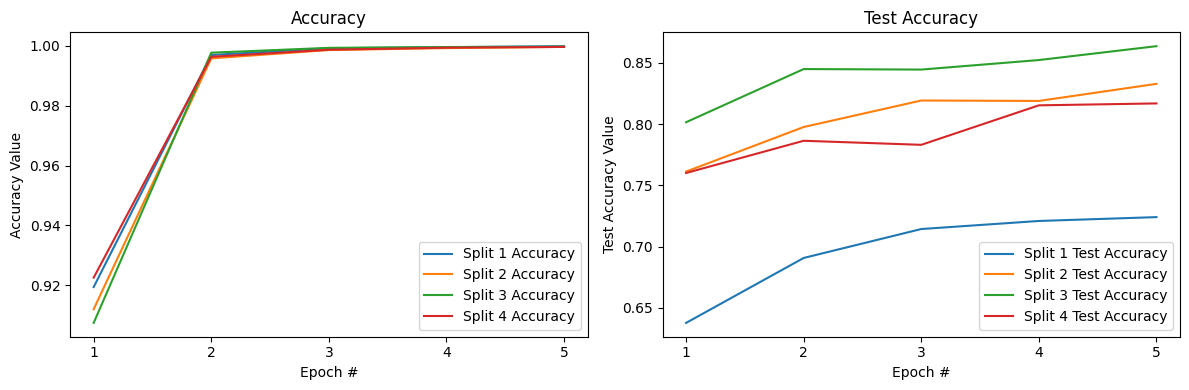

In [27]:
plot_metrics(all_histories, ["accuracy" , "val_accuracy"] )

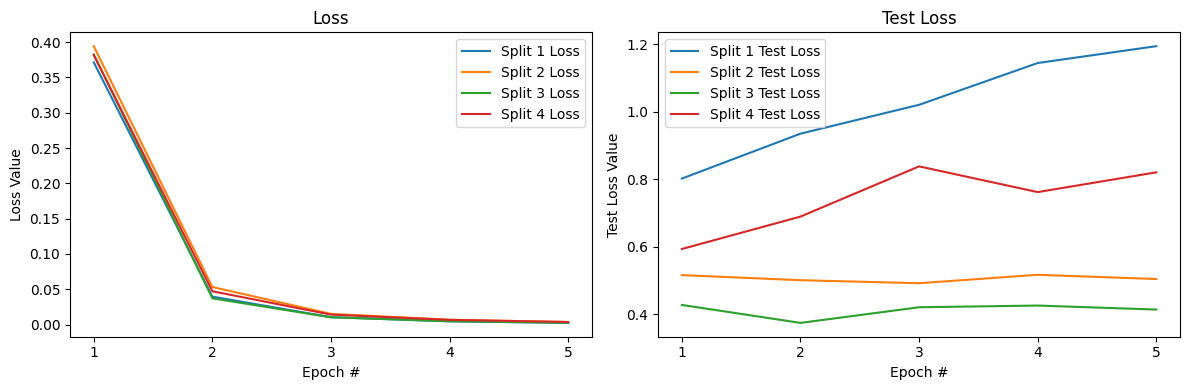

In [28]:
plot_metrics(all_histories, ["loss" , "val_loss"] )

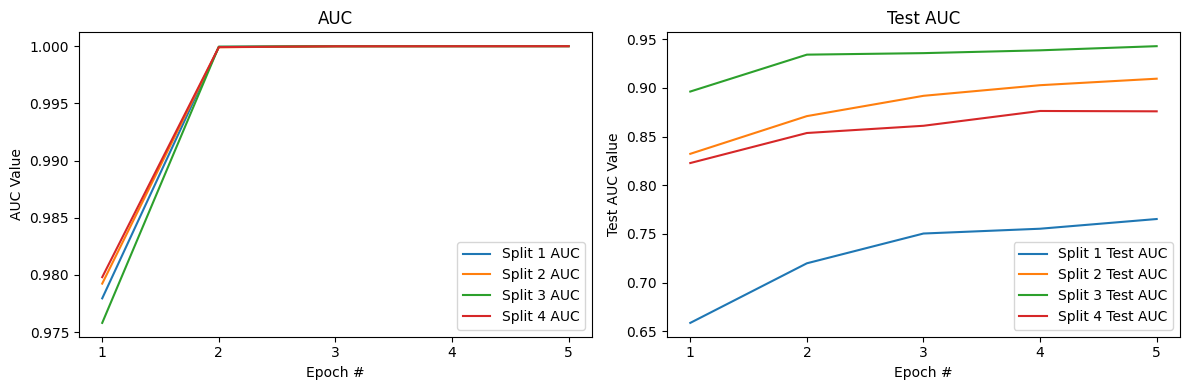

In [29]:
plot_metrics(all_histories, ["auc" , "val_auc"] )

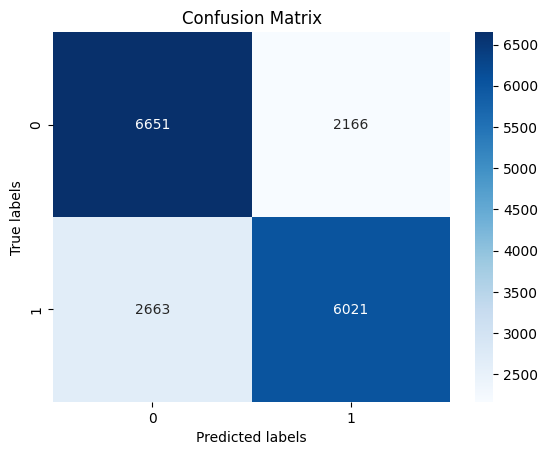

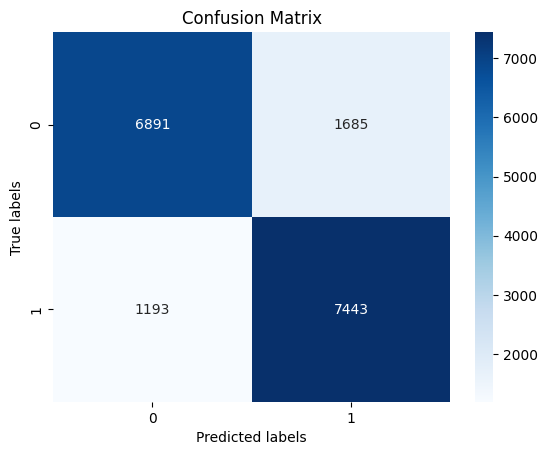

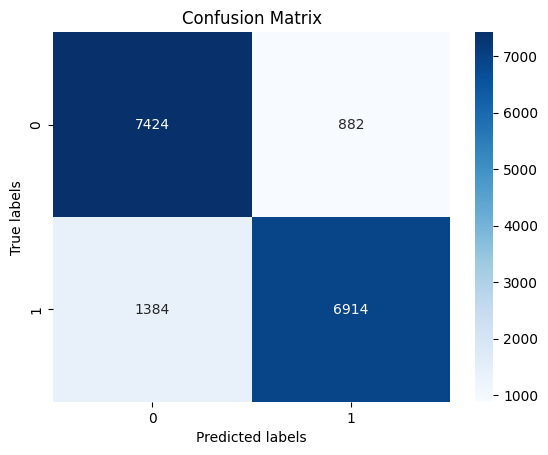

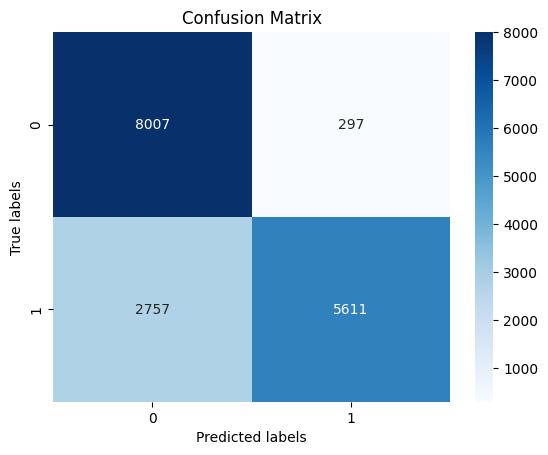

In [28]:
for i in range(4):
    plot_confusion_matrix(all_y_true[i], all_y_pred_binary[i] , [0 , 1])

In [30]:
for i in range(4):
    print(classification_report(all_y_true[i], all_y_pred_binary[i]))

              precision    recall  f1-score   support

           0       0.71      0.75      0.73      8817
           1       0.74      0.69      0.71      8684

    accuracy                           0.72     17501
   macro avg       0.72      0.72      0.72     17501
weighted avg       0.72      0.72      0.72     17501

              precision    recall  f1-score   support

           0       0.85      0.80      0.83      8576
           1       0.82      0.86      0.84      8636

    accuracy                           0.83     17212
   macro avg       0.83      0.83      0.83     17212
weighted avg       0.83      0.83      0.83     17212

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      8306
           1       0.89      0.83      0.86      8298

    accuracy                           0.86     16604
   macro avg       0.86      0.86      0.86     16604
weighted avg       0.86      0.86      0.86     16604

              preci